### Imports
---

In [5]:
import torch
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split as tts
import os
import pickle
import importlib
from typing import Literal

import datasets
importlib.reload(datasets)
from datasets import DatasetGenerator, PairedMNISTDataset

import type_defs
importlib.reload(type_defs)
from type_defs import Config, DataLoaderSet

import helpers
importlib.reload(helpers)
import helpers

import models
importlib.reload(models)
from models import TinyCNN, TinyCNN_Headless, TinyCNN_Head, WrapperModelTrainHead, CustomUNET, DynamicCNN

### Constants
---

In [6]:
DEVICE: Literal["cpu", "cuda"] = "cuda" if torch.cuda.is_available() else "cpu"

config_yaml = helpers.load_yaml(r"configs/tiny_config.yaml")
CONFIG: Config = Config(**config_yaml)

MODEL_FOLDER: str = CONFIG.save_locations.model_folder
FILE_FOLDER: str = CONFIG.save_locations.file_folder
IMAGE_FOLDER: str = CONFIG.save_locations.image_folder

BASE: str = CONFIG.dataset.base_ds
AUXILIARY: str = CONFIG.dataset.aux_ds

BATCH_SIZE: int = CONFIG.dataset.batch_size
CLASSIFIER_ID: str = CONFIG.classifier.identifier

In [7]:
# folder creation

if not os.path.exists(f"{MODEL_FOLDER}"):
    os.mkdir(f"{MODEL_FOLDER}")

if not os.path.exists(f"{FILE_FOLDER}"):
    os.mkdir(f"{FILE_FOLDER}")

if not os.path.exists(f"{IMAGE_FOLDER}"):
    os.mkdir(f"{IMAGE_FOLDER}")

### Dataset Generation
---

In [8]:
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True)

x_train = mnist_train.data.numpy()
y_train = mnist_train.targets.numpy()

x_test = mnist_test.data.numpy()
y_test = mnist_test.targets.numpy()

x_test, x_val, y_test, y_val = tts(
    x_test, y_test, test_size=.5, random_state=CONFIG.dataset.rng_seed
)

In [9]:
train_ds_gen: DatasetGenerator = DatasetGenerator(
    images = x_train,
    labels = y_train,
    subset_ratio = CONFIG.dataset.base_sample_ratio,
    base_ds=BASE,
    aux_ds=AUXILIARY
)

base_images_train, base_labels_train = train_ds_gen.build_base_dataset()
aux_images_train, aux_labels_train = train_ds_gen.build_aux_dataset()

print(f"Train Dataset Base Size: {len(base_images_train)}")
print(f"Train Dataset Aux Size: {len(aux_images_train)}")

test_ds_gen: DatasetGenerator = DatasetGenerator(
    images = x_test,
    labels = y_test,
    subset_ratio = .5,
    base_ds=BASE,
    aux_ds=AUXILIARY
)

base_images_test, base_labels_test = test_ds_gen.build_base_dataset()
aux_images_test, aux_labels_test = test_ds_gen.build_aux_dataset()

print(f"Test Dataset Base Size: {len(base_images_test)}")
print(f"Test Dataset Aux Size: {len(aux_images_test)}")

val_ds_gen: DatasetGenerator = DatasetGenerator(
    images = x_val,
    labels = y_val,
    subset_ratio = .5,
    base_ds=BASE,
    aux_ds=AUXILIARY
)

base_images_val, base_labels_val = val_ds_gen.build_base_dataset()
aux_images_val, aux_labels_val = val_ds_gen.build_aux_dataset()

print(f"Validation Dataset Base Size: {len(base_images_val)}")
print(f"Validation Dataset Aux Size: {len(aux_images_val)}")


Train Dataset Base Size: 6000
Train Dataset Aux Size: 54000
Test Dataset Base Size: 2500
Test Dataset Aux Size: 2500
Validation Dataset Base Size: 2500
Validation Dataset Aux Size: 2500


In [10]:
train_dataset: PairedMNISTDataset = PairedMNISTDataset(
    base_images=base_images_train,
    base_labels=base_labels_train,
    aux_images=aux_images_train,
    aux_labels=aux_labels_train
)

test_dataset: PairedMNISTDataset = PairedMNISTDataset(
    base_images=base_images_test,
    base_labels=base_labels_test,
    aux_images=aux_images_test,
    aux_labels=aux_labels_test
)

val_dataset: PairedMNISTDataset = PairedMNISTDataset(
    base_images=base_images_val,
    base_labels=base_labels_val,
    aux_images=aux_images_val,
    aux_labels=aux_labels_val
)

train_loader: DataLoader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

test_loader: DataLoader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    drop_last=True
)

val_loader: DataLoader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    drop_last=True
)

dl_set = DataLoaderSet(
    train_loader=train_loader,
    test_loader=test_loader,
    val_loader=val_loader
)

In [98]:
for x, y, z in val_loader:
    INPUT_SHAPE = x.shape
    break

print(f"Shape of Inputs: {INPUT_SHAPE}")

Shape of Inputs: torch.Size([64, 3, 32, 32])


In [102]:
model = DynamicCNN(
    input_shape=INPUT_SHAPE,
    num_filters=CONFIG.classifier.num_filters,
    kernel_size=CONFIG.classifier.kernel_size,
    stride=CONFIG.classifier.stride,
    padding=CONFIG.classifier.padding,
    mlp_layer_sizes=CONFIG.classifier.mlp_layer_sizes,
    num_classes=CONFIG.classifier.num_classes
)

base_model_trainer = helpers.Trainer(
    model = model,
    dataloaders=dl_set
)

base_model_trainer.classification_train_loop(
    filename = "D:/Downloads/thisisatest.pt",
    device=DEVICE,
    mode="base_only",
    num_epochs=10
)


	Epoch 1: 1.4206 54.32 0.6609 79.53 <- New Best
	Epoch 2: 0.5777 81.37 0.4764 86.42 <- New Best
	Epoch 3: 0.4316 86.37 0.3902 88.46 <- New Best
	Epoch 4: 0.3547 88.81 0.3459 89.94 <- New Best
	Epoch 5: 0.3065 90.39 0.318 90.38 <- New Best
	Epoch 6: 0.2716 91.05 0.2917 90.87 <- New Best
	Epoch 7: 0.241 92.44 0.2854 91.39 <- New Best
	Epoch 8: 0.2289 92.84 0.2659 92.03 <- New Best
	Epoch 9: 0.2115 93.25 0.2656 92.19 <- New Best
	Epoch 10: 0.1988 93.6 0.2865 91.91

### Base Model Training
---

In [ ]:
base_model_file = f"{MODEL_FOLDER}/{CLASSIFIER_ID}_base_classifier_{BASE}+{AUXILIARY}.pt"

if not os.path.exists(base_model_file):
    num_base_epochs = 50

    model = DynamicCNN(
        input_shape=INPUT_SHAPE,
        num_filters=CONFIG.classifier.num_filters,
        kernel_size=CONFIG.classifier.kernel_size,
        stride=CONFIG.classifier.stride,
        padding=CONFIG.classifier.padding,
        mlp_layer_sizes=CONFIG.classifier.mlp_layer_sizes,
        num_classes=CONFIG.classifier.num_classes
    )
    model.to(DEVICE)
    optimizer = optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    base_early_stopper = helpers.EarlyStopper(
        patience=5,
        min_delta=0
    )

    base_best_val = 1e7

    for epoch in range(num_base_epochs):
        train_loss, train_acc = helpers.classification_run(
            model=model,
            optimizer=optimizer,
            dataloader=train_loader,
            mode="base_only",
            device=DEVICE,
        )

        val_loss, val_acc = helpers.classification_run(
            model=model,
            optimizer=optimizer,
            dataloader=val_loader,
            mode="base_only",
            device=DEVICE,
            train=False
        )

        print(f"\nEpoch {epoch+1}:", round(train_loss, 4), round(train_acc*100, 2), round(val_loss, 4), round(val_acc*100, 2), end="")

        if val_loss < base_best_val:
            print(" <- New Best", end="")
            base_best_val = val_loss
            torch.save(model.state_dict(), base_model_file)

        if base_early_stopper(val_loss):
            print("\n-- Stopped -- ")
            break


Epoch 1: 1.4274 53.61 0.7204 77.0 <- New Best
Epoch 2: 0.6017 80.49 0.5298 83.93 <- New Best
Epoch 3: 0.4279 86.11 0.3884 87.86 <- New Best
Epoch 4: 0.3323 89.2 0.3093 90.06 <- New Best
Epoch 5: 0.2781 91.03 0.2873 90.99 <- New Best
Epoch 6: 0.2397 92.17 0.2523 91.83 <- New Best
Epoch 7: 0.2204 92.69 0.2546 92.15
Epoch 8: 0.2025 93.3 0.2291 93.03 <- New Best
Epoch 9: 0.186 93.92 0.2247 93.43 <- New Best
Epoch 10: 0.182 93.88 0.2225 92.87 <- New Best
Epoch 11: 0.1669 94.49 0.2249 93.43
Epoch 12: 0.1561 94.91 0.2235 93.23
Epoch 13: 0.1519 95.09 0.216 93.59 <- New Best
Epoch 14: 0.1371 95.6 0.2291 93.43
Epoch 15: 0.131 95.56 0.2246 93.51
Epoch 16: 0.1271 95.61 0.2352 92.91
Epoch 17: 0.1257 95.61 0.2325 93.19
Epoch 18: 0.1194 95.82 0.2186 93.71
-- Stopped -- 


### Mixed Model Training
---

In [78]:
mixed_model_file = f"{MODEL_FOLDER}/{CLASSIFIER_ID}_mixed_classifier_{BASE}+{AUXILIARY}.pt"

if not os.path.exists(mixed_model_file):
    num_mixed_epochs = 50

    model = DynamicCNN(
        input_shape=INPUT_SHAPE,
        num_filters=CONFIG.classifier.num_filters,
        kernel_size=CONFIG.classifier.kernel_size,
        stride=CONFIG.classifier.stride,
        padding=CONFIG.classifier.padding,
        mlp_layer_sizes=CONFIG.classifier.mlp_layer_sizes,
        num_classes=CONFIG.classifier.num_classes
    )
    model.to(DEVICE)
    optimizer = optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    mixed_early_stopper = helpers.EarlyStopper(
        patience=5,
        min_delta=0
    )

    mixed_best_val = 1e7

    for epoch in range(num_mixed_epochs):
        train_loss, train_acc = helpers.classification_run(
            model=model,
            optimizer=optimizer,
            dataloader=train_loader,
            mode="base_and_aux",
            device=DEVICE,
        )

        val_loss, val_acc = helpers.classification_run(
            model=model,
            optimizer=optimizer,
            dataloader=val_loader,
            device=DEVICE,
            mode="base_only",
            train=False
        )

        print(f"\nEpoch {epoch+1}:", round(train_loss, 4), round(train_acc*100, 2), round(val_loss, 4), round(val_acc*100, 2), end="")

        if val_loss < mixed_best_val:
            print(" <- New Best", end="")
            mixed_best_val = val_loss
            torch.save(model.state_dict(), mixed_model_file)

        if mixed_early_stopper(val_loss):
            print("\n-- Stopped -- ")
            break


Epoch 1: 1.193 63.68 0.6502 79.49 <- New Best
Epoch 2: 0.4648 85.33 0.4647 85.94 <- New Best
Epoch 3: 0.3463 89.42 0.3829 88.14 <- New Best
Epoch 4: 0.2891 91.25 0.3354 90.18 <- New Best
Epoch 5: 0.2421 92.56 0.2934 90.38 <- New Best
Epoch 6: 0.2113 93.44 0.2825 90.79 <- New Best
Epoch 7: 0.1988 94.19 0.2675 90.99 <- New Best
Epoch 8: 0.1898 94.08 0.2547 91.91 <- New Best
Epoch 9: 0.1858 94.29 0.2443 92.07 <- New Best
Epoch 10: 0.1627 94.79 0.2468 91.99
Epoch 11: 0.1566 95.3 0.2316 92.63 <- New Best
Epoch 12: 0.1519 95.31 0.2321 92.67
Epoch 13: 0.1381 95.64 0.225 92.99 <- New Best
Epoch 14: 0.1411 95.63 0.2919 90.22
Epoch 15: 0.1472 95.61 0.2127 93.47 <- New Best
Epoch 16: 0.1373 95.76 0.2276 92.83
Epoch 17: 0.1301 95.91 0.2156 92.95
Epoch 18: 0.1259 96.06 0.2285 92.51
Epoch 19: 0.1208 96.27 0.2126 92.83 <- New Best
Epoch 20: 0.1195 96.3 0.203 93.67 <- New Best

### Supervised Contrastive Model Training
---

#### Body Training + Temperature Hyperparameter Selection

In [79]:
num_contrast_epochs = 200
temp_range = np.linspace(0.05, .15, 3)
best_val_loss = 1000*np.ones(len(temp_range))

for i, temp in enumerate(temp_range):
    model = DynamicCNN(
        input_shape=INPUT_SHAPE,
        num_filters=CONFIG.classifier.num_filters,
        kernel_size=CONFIG.classifier.kernel_size,
        stride=CONFIG.classifier.stride,
        padding=CONFIG.classifier.padding,
        mlp_layer_sizes=CONFIG.classifier.mlp_layer_sizes,
        num_classes=CONFIG.classifier.num_classes,
        headless=True
    )
    headless_model_output_size = CONFIG.classifier.mlp_layer_sizes[-1]
    proj_head = torch.nn.Linear(headless_model_output_size, 128)

    model.to(DEVICE)
    proj_head.to(DEVICE)

    contrast_optimizer = optim.Adam(
        list(model.parameters()) + list(proj_head.parameters()),
        lr=0.001, 
        weight_decay=1e-5
    )

    contrast_early_stopper = helpers.EarlyStopper(
        patience=10,
        min_delta=0
    )

    for epoch in range(num_contrast_epochs):
        train_loss = helpers.contrastive_run(
            model=model,
            proj_head=proj_head,
            optimizer=contrast_optimizer,
            dataloader=train_loader,
            device=DEVICE,
            temperature=temp
        )

        val_loss = helpers.contrastive_run(
            model=model,
            proj_head=proj_head,
            optimizer=contrast_optimizer,
            dataloader=val_loader,
            device=DEVICE,
            train=False,
            temperature=temp
        )

        if val_loss < best_val_loss[i]:
            best_val_loss[i] = val_loss
            torch.save(model.state_dict(), f"{MODEL_FOLDER}/{CLASSIFIER_ID}_contrast_body_{BASE}+{AUXILIARY}_{round(temp, 2)}.pt")
            torch.save(proj_head.state_dict(), f"{MODEL_FOLDER}/{CLASSIFIER_ID}_contrast_proj_{BASE}+{AUXILIARY}_{round(temp, 2)}.pt")

        if contrast_early_stopper(val_loss):
            print(f"Best Val Loss ({round(temp, 2)}):", best_val_loss[i])
            break

        if (epoch+1 == num_contrast_epochs):
            print(f"Best Val Loss ({round(temp, 2)}):", best_val_loss[i])

Best Val Loss (0.05): 2.9322373744768973
Best Val Loss (0.1): 2.930969867950831
Best Val Loss (0.15): 2.927713840435713


#### Supervised Contrastive Learning Head Training

In [80]:
best_temp = round(temp_range[np.argmin(best_val_loss)], 2)
print(f"Best temp: {best_temp}")

Best temp: 0.15


In [81]:
num_class_epochs = 100

contrast_body = DynamicCNN(
        input_shape=INPUT_SHAPE,
        num_filters=CONFIG.classifier.num_filters,
        kernel_size=CONFIG.classifier.kernel_size,
        stride=CONFIG.classifier.stride,
        padding=CONFIG.classifier.padding,
        mlp_layer_sizes=CONFIG.classifier.mlp_layer_sizes,
        num_classes=CONFIG.classifier.num_classes,
        headless=True
    )
contrast_body.load_state_dict(torch.load(f"{MODEL_FOLDER}/{CLASSIFIER_ID}_contrast_body_{BASE}+{AUXILIARY}_{best_temp}.pt", weights_only=True))

headless_model_output_size = CONFIG.classifier.mlp_layer_sizes[-1]
class_head = torch.nn.Linear(headless_model_output_size, CONFIG.classifier.num_classes)

wrapped_model = WrapperModelTrainHead(
    body = contrast_body,
    head = class_head
)
wrapped_model.to(DEVICE)
optimizer = optim.Adam(
    wrapped_model.head.parameters(),
    lr = 0.001,
    weight_decay = 1e-5
)

contrast_early_stopper = helpers.EarlyStopper(
    patience=5,
    min_delta=0
)

contrast_best = {
    "val_loss": 1000,
    "val_acc": 0
}

for epoch in range(num_class_epochs):
    train_loss, train_acc = helpers.classification_run(
        model=wrapped_model,
        optimizer=optimizer,
        dataloader=train_loader,
        mode="base_and_aux",
        device=DEVICE,
    )

    val_loss, val_acc = helpers.classification_run(
        model=wrapped_model,
        optimizer=optimizer,
        dataloader=val_loader,
        device=DEVICE,
        mode="base_only",
        train=False
    )

    print(f"\nEpoch {epoch+1}:", round(train_loss, 4), round(train_acc*100, 2), round(val_loss, 4), round(val_acc*100, 2), end="")

    if val_loss < contrast_best["val_loss"]:
        print(" <- New Best", end="")
        contrast_best["val_loss"] = val_loss
        contrast_best["val_acc"] = val_acc
        torch.save(wrapped_model.state_dict(), f"{MODEL_FOLDER}/{CLASSIFIER_ID}_contrast_classifier_{BASE}+{AUXILIARY}.pt")

    if contrast_early_stopper(val_loss):
        print("\n")
        print("Best Val Loss:", contrast_best["val_loss"])
        print("Best Val Acc:", round(contrast_best["val_acc"]*100, 2))
        break

    if (epoch+1 == num_class_epochs):
        print("\n")
        print("Best Val Loss:", contrast_best["val_loss"])
        print("Best Val Acc:", round(contrast_best["val_acc"]*100, 2))


Epoch 1: 2.0324 56.53 1.9637 81.89 <- New Best
Epoch 2: 1.6522 92.07 1.7105 91.23 <- New Best
Epoch 3: 1.3574 95.7 1.5025 93.11 <- New Best
Epoch 4: 1.1333 97.03 1.3328 93.79 <- New Best
Epoch 5: 0.9556 97.45 1.1937 94.19 <- New Best
Epoch 6: 0.8276 97.63 1.0797 94.23 <- New Best
Epoch 7: 0.7231 97.66 0.9847 94.23 <- New Best
Epoch 8: 0.641 97.77 0.9045 94.19 <- New Best
Epoch 9: 0.5755 97.72 0.836 94.31 <- New Best
Epoch 10: 0.5219 97.7 0.7772 94.39 <- New Best
Epoch 11: 0.4762 97.87 0.7256 94.55 <- New Best
Epoch 12: 0.4417 97.88 0.6804 94.59 <- New Best
Epoch 13: 0.4021 98.06 0.6405 94.51 <- New Best
Epoch 14: 0.3803 97.95 0.605 94.47 <- New Best
Epoch 15: 0.3562 97.9 0.5733 94.43 <- New Best
Epoch 16: 0.3292 97.76 0.545 94.39 <- New Best
Epoch 17: 0.3123 97.87 0.5194 94.39 <- New Best
Epoch 18: 0.2934 98.06 0.4964 94.39 <- New Best
Epoch 19: 0.2795 97.79 0.4754 94.39 <- New Best
Epoch 20: 0.2648 98.11 0.4561 94.35 <- New Best
Epoch 21: 0.2482 98.08 0.4385 94.31 <- New Best
Epoch 2

### Compare Accuracies Between Models

In [86]:
base_model = DynamicCNN(
        input_shape=INPUT_SHAPE,
        num_filters=CONFIG.classifier.num_filters,
        kernel_size=CONFIG.classifier.kernel_size,
        stride=CONFIG.classifier.stride,
        padding=CONFIG.classifier.padding,
        mlp_layer_sizes=CONFIG.classifier.mlp_layer_sizes,
        num_classes=CONFIG.classifier.num_classes
    )
base_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/{CLASSIFIER_ID}_base_classifier_{BASE}+{AUXILIARY}.pt", weights_only=True))
base_model.to(DEVICE)
base_loss, base_acc = helpers.classification_run(
    model=base_model,
    optimizer=optimizer,
    dataloader=val_loader,
    device=DEVICE,
    mode="base_only",
    train=False
)


mixed_model = DynamicCNN(
        input_shape=INPUT_SHAPE,
        num_filters=CONFIG.classifier.num_filters,
        kernel_size=CONFIG.classifier.kernel_size,
        stride=CONFIG.classifier.stride,
        padding=CONFIG.classifier.padding,
        mlp_layer_sizes=CONFIG.classifier.mlp_layer_sizes,
        num_classes=CONFIG.classifier.num_classes
    )
mixed_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/{CLASSIFIER_ID}_mixed_classifier_{BASE}+{AUXILIARY}.pt", weights_only=True))
mixed_model.to(DEVICE)
mixed_loss, mixed_acc = helpers.classification_run(
    model=mixed_model,
    optimizer=optimizer,
    dataloader=val_loader,
    device=DEVICE,
    mode="base_only",
    train=False
)


contrast_body = DynamicCNN(
        input_shape=INPUT_SHAPE,
        num_filters=CONFIG.classifier.num_filters,
        kernel_size=CONFIG.classifier.kernel_size,
        stride=CONFIG.classifier.stride,
        padding=CONFIG.classifier.padding,
        mlp_layer_sizes=CONFIG.classifier.mlp_layer_sizes,
        num_classes=CONFIG.classifier.num_classes,
        headless=True
    )

headless_model_output_size = CONFIG.classifier.mlp_layer_sizes[-1]
contrast_head = torch.nn.Linear(headless_model_output_size, CONFIG.classifier.num_classes)

contrast_model = WrapperModelTrainHead(
    body=contrast_body,
    head=contrast_head
)
contrast_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/{CLASSIFIER_ID}_contrast_classifier_{BASE}+{AUXILIARY}.pt", weights_only=True))
contrast_model.to(DEVICE)

contrast_loss, contrast_acc = helpers.classification_run(
    model=contrast_model,
    optimizer=optimizer,
    dataloader=val_loader,
    device=DEVICE,
    mode="base_only",
    train=False
)

print(f"Base Model:\n\t Validation Loss: {round(base_loss, 4)}\tValidation Accuracy: {round(base_acc*100, 2)}")
print(f"Base + Aux Mixed:\n\t Validation Loss: {round(mixed_loss, 4)}\tValidation Accuracy: {round(mixed_acc*100, 2)}")
print(f"Base + Aux Contrastive:\n\t Validation Loss: {round(contrast_loss, 4)}\tValidation Accuracy: {round(contrast_acc*100, 2)}")

Base Model:
	 Validation Loss: 0.216	Validation Accuracy: 93.59
Base + Aux Mixed:
	 Validation Loss: 0.203	Validation Accuracy: 93.67
Base + Aux Contrastive:
	 Validation Loss: 0.2235	Validation Accuracy: 94.59


### Plot Latent Space Representations

In [83]:
base_model = DynamicCNN(
        input_shape=INPUT_SHAPE,
        num_filters=CONFIG.classifier.num_filters,
        kernel_size=CONFIG.classifier.kernel_size,
        stride=CONFIG.classifier.stride,
        padding=CONFIG.classifier.padding,
        mlp_layer_sizes=CONFIG.classifier.mlp_layer_sizes,
        num_classes=CONFIG.classifier.num_classes
    )
base_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/{CLASSIFIER_ID}_base_classifier_{BASE}+{AUXILIARY}.pt", weights_only=True))
base_model.eval()


mixed_model = DynamicCNN(
        input_shape=INPUT_SHAPE,
        num_filters=CONFIG.classifier.num_filters,
        kernel_size=CONFIG.classifier.kernel_size,
        stride=CONFIG.classifier.stride,
        padding=CONFIG.classifier.padding,
        mlp_layer_sizes=CONFIG.classifier.mlp_layer_sizes,
        num_classes=CONFIG.classifier.num_classes
    )
mixed_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/{CLASSIFIER_ID}_mixed_classifier_{BASE}+{AUXILIARY}.pt", weights_only=True))
mixed_model.eval()


contrast_body = DynamicCNN(
        input_shape=INPUT_SHAPE,
        num_filters=CONFIG.classifier.num_filters,
        kernel_size=CONFIG.classifier.kernel_size,
        stride=CONFIG.classifier.stride,
        padding=CONFIG.classifier.padding,
        mlp_layer_sizes=CONFIG.classifier.mlp_layer_sizes,
        num_classes=CONFIG.classifier.num_classes,
        headless=True
    )

headless_model_output_size = CONFIG.classifier.mlp_layer_sizes[-1]
contrast_head = torch.nn.Linear(headless_model_output_size, CONFIG.classifier.num_classes)

contrast_model = WrapperModelTrainHead(
    body=contrast_body,
    head=contrast_head
)

contrast_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/{CLASSIFIER_ID}_contrast_classifier_{BASE}+{AUXILIARY}.pt", weights_only=True))
contrast_model.eval()

contrast_model.to(DEVICE)
base_model.to(DEVICE)
mixed_model.to(DEVICE)

DynamicCNN(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (mlp_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=32, bias=True)
  )
  (output_layer): Linear(in_features=32, out_features=10, bias=True)
)

In [84]:
embed_size = CONFIG.classifier.mlp_layer_sizes[-1]

base_embeds = np.zeros((len(test_dataset), embed_size))
mixed_embeds_base = np.zeros((len(test_dataset), embed_size))
mixed_embeds_aux = np.zeros((len(test_dataset), embed_size))
contrast_embeds_base = np.zeros((len(test_dataset), embed_size))
contrast_embeds_aux = np.zeros((len(test_dataset), embed_size))
labels = np.zeros(len(test_dataset))

test_loader.dataset.unique_sources = True
bs = BATCH_SIZE

for i, (x,y,z) in enumerate(test_loader):
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    with torch.no_grad():
        base_outputs = base_model(x)[-2].cpu().numpy()
        mixed_outputs_base = mixed_model(x)[-2].cpu().numpy()
        mixed_outputs_aux = mixed_model(y)[-2].cpu().numpy()
        contrast_outputs_base = contrast_model(x)[-2].cpu().numpy()
        contrast_outputs_aux = contrast_model(y)[-2].cpu().numpy()

        base_embeds[i*bs:i*bs+bs] = base_outputs
        mixed_embeds_base[i*bs:i*bs+bs] = mixed_outputs_base
        mixed_embeds_aux[i*bs:i*bs+bs] = mixed_outputs_aux
        contrast_embeds_base[i*bs:i*bs+bs] = contrast_outputs_base
        contrast_embeds_aux[i*bs:i*bs+bs] = contrast_outputs_aux
        labels[i*bs:i*bs+bs] = z.cpu()


In [11]:
len(val_loader.dataset)

2500

C:\Users\justl\AppData\Local\Temp\ipykernel_23528\2509416375.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab20 = plt.cm.get_cmap('tab20')
C:\Users\justl\AppData\Local\Temp\ipykernel_23528\2509416375.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab20 = plt.cm.get_cmap('tab20')


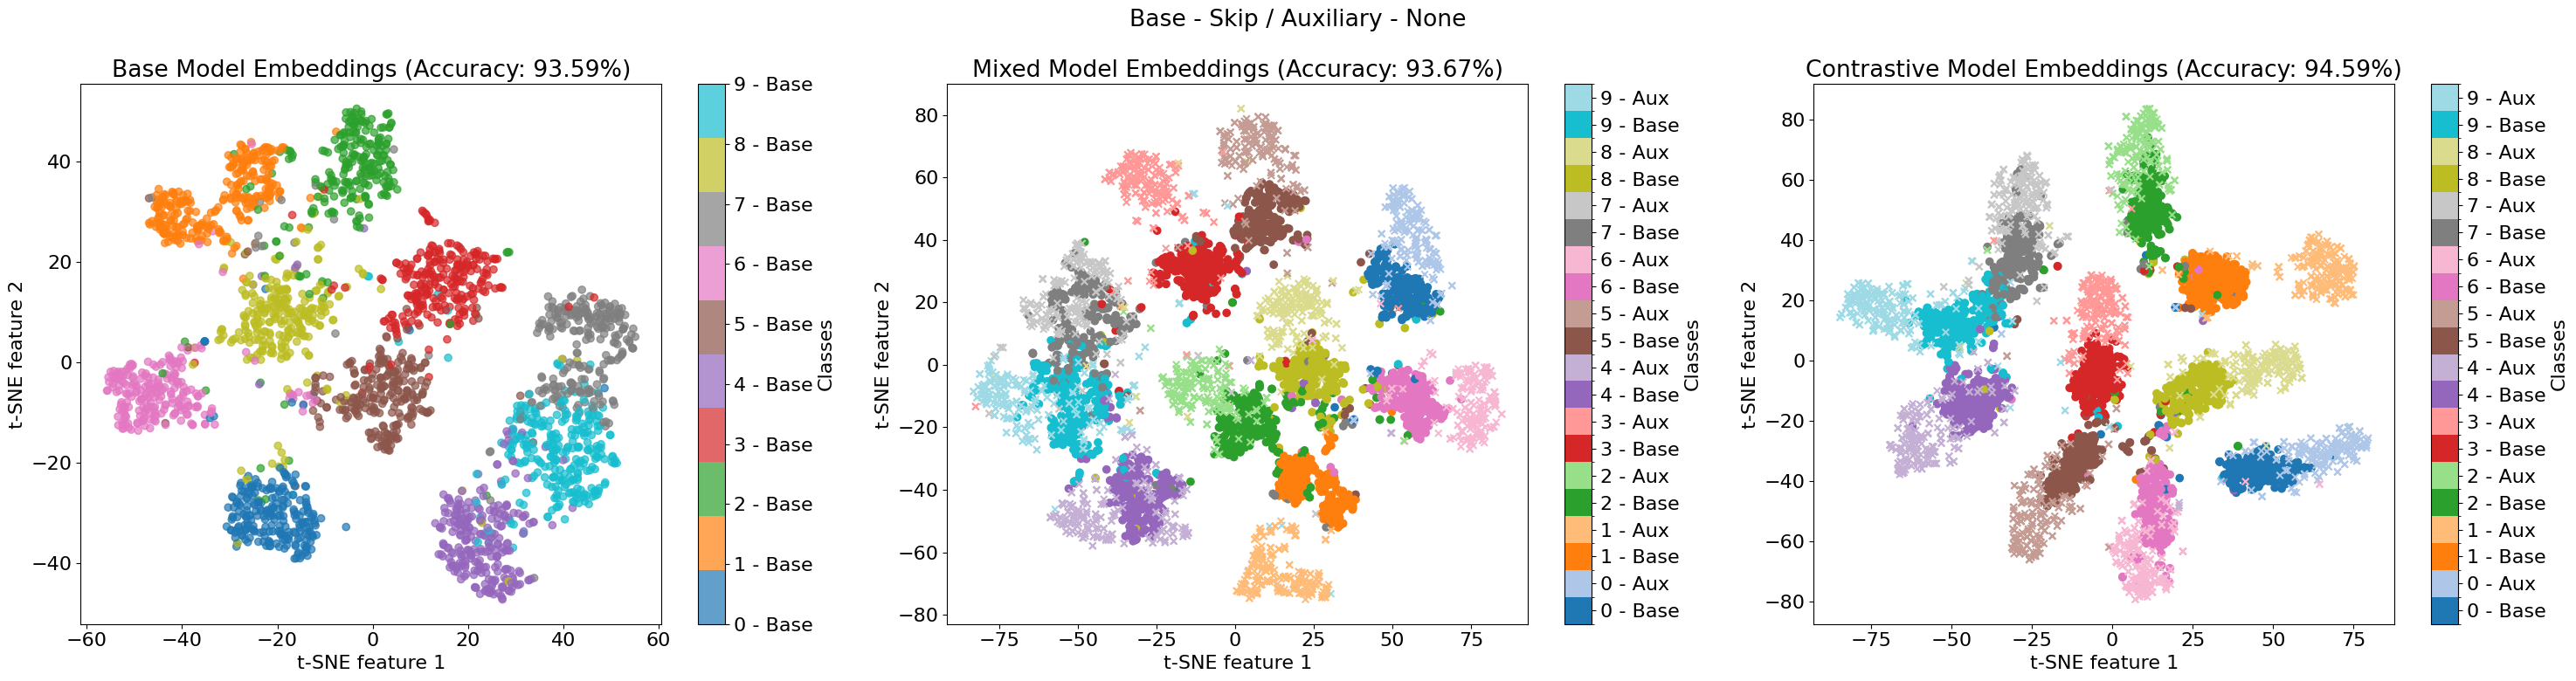

In [85]:
mixed_labels = np.concatenate((labels*2, labels*2+1))
mixed_embeds = np.concatenate((mixed_embeds_base, mixed_embeds_aux))

contrast_labels = np.concatenate((labels*2, labels*2+1))
contrast_embeds = np.concatenate((contrast_embeds_base, contrast_embeds_aux))

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

plt.rcParams['font.size'] = 16

# Perform t-SNE for all three embedding sets
tsne = TSNE(n_components=2, random_state=42)
base_tsne = tsne.fit_transform(base_embeds)
mixed_tsne = tsne.fit_transform(mixed_embeds)
contrast_tsne = tsne.fit_transform(contrast_embeds)

# Convert labels to numpy if it's a torch tensor
if isinstance(labels, torch.Tensor):
    labels = labels.numpy()

# Create three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

# Plot for base embeddings
scatter1 = ax1.scatter(base_tsne[:, 0], base_tsne[:, 1], c=labels, cmap='tab10', alpha=.7)
ax1.set_title(f'Base Model Embeddings (Accuracy: {round(base_acc*100, 2)}%)')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
cbar = fig.colorbar(scatter1, ax=ax1)
ticks = np.arange(0, 10)
c_labels = [ 
    "0 - Base",
    "1 - Base",
    "2 - Base",
    "3 - Base",
    "4 - Base",
    "5 - Base",
    "6 - Base",
    "7 - Base",
    "8 - Base",
    "9 - Base",
]
cbar.set_ticks(ticks)
cbar.set_ticklabels(c_labels)
cbar.set_label("Classes")

tab20 = plt.cm.get_cmap('tab20')
color_dict = {i: tab20(i/20) for i in range(20)}

scatter2a = ax2.scatter(mixed_tsne[:len(mixed_tsne)//2, 0], mixed_tsne[:len(mixed_tsne)//2, 1], c=[color_dict[label] for label in mixed_labels[:len(mixed_tsne)//2]])
scatter2b = ax2.scatter(mixed_tsne[len(mixed_tsne)//2:, 0], mixed_tsne[len(mixed_tsne)//2:, 1], c=[color_dict[label] for label in mixed_labels[len(mixed_tsne)//2:]], marker="x", s=30)
ax2.set_title(f'Mixed Model Embeddings (Accuracy: {round(mixed_acc*100, 2)}%)')
ax2.set_xlabel('t-SNE feature 1')
ax2.set_ylabel('t-SNE feature 2')
colors = [color_dict[i] for i in range(20)]
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(21)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax2, ticks=np.arange(0.5, 20))

c_labels = [
    "0 - Base", "0 - Aux",
    "1 - Base", "1 - Aux",
    "2 - Base", "2 - Aux",
    "3 - Base", "3 - Aux",
    "4 - Base", "4 - Aux",
    "5 - Base", "5 - Aux",
    "6 - Base", "6 - Aux",
    "7 - Base", "7 - Aux",
    "8 - Base", "8 - Aux",
    "9 - Base", "9 - Aux",
]
cbar.set_ticklabels(c_labels)
cbar.set_label("Classes")


# Plot for contrast embeddings
tab20 = plt.cm.get_cmap('tab20')
color_dict = {i: tab20(i/20) for i in range(20)}

scatter3a = ax3.scatter(contrast_tsne[:len(contrast_tsne)//2, 0], contrast_tsne[:len(contrast_tsne)//2, 1], c=[color_dict[label] for label in contrast_labels[:len(contrast_tsne)//2]])
scatter3b = ax3.scatter(contrast_tsne[len(contrast_tsne)//2:, 0], contrast_tsne[len(contrast_tsne)//2:, 1], c=[color_dict[label] for label in contrast_labels[len(contrast_tsne)//2:]], marker="x", s=30)
ax3.set_title(f'Contrastive Model Embeddings (Accuracy: {round(contrast_acc*100, 2)}%)')
ax3.set_xlabel('t-SNE feature 1')
ax3.set_ylabel('t-SNE feature 2')
colors = [color_dict[i] for i in range(20)]
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(21)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax3, ticks=np.arange(0.5, 20))

c_labels = [
    "0 - Base", "0 - Aux",
    "1 - Base", "1 - Aux",
    "2 - Base", "2 - Aux",
    "3 - Base", "3 - Aux",
    "4 - Base", "4 - Aux",
    "5 - Base", "5 - Aux",
    "6 - Base", "6 - Aux",
    "7 - Base", "7 - Aux",
    "8 - Base", "8 - Aux",
    "9 - Base", "9 - Aux",
]
cbar.set_ticklabels(c_labels)
cbar.set_label("Classes")

fig.suptitle(f"Base - {BASE.capitalize()} / Auxiliary - {AUXILIARY.capitalize()}")

plt.tight_layout()
plt.savefig(f'{IMAGE_FOLDER}/{CLASSIFIER_ID}_tsne_{BASE}+{AUXILIARY}.pdf', format="pdf", dpi=300)
plt.show()

### Calculate Divergence Between Layers of the Networks

In [46]:
base_model = TinyCNN()
base_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/{CLASSIFIER_ID}_base_classifier_{BASE}+{AUXILIARY}.pt", weights_only=True))
base_model.eval()

mixed_model = TinyCNN()
mixed_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/{CLASSIFIER_ID}_mixed_classifier_{BASE}+{AUXILIARY}.pt", weights_only=True))
mixed_model.eval()

contrast_body = TinyCNN_Headless()
contrast_head = TinyCNN_Head()

contrast_model = WrapperModelTrainHead(
    body=contrast_body,
    head=contrast_head
)

contrast_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/{CLASSIFIER_ID}_contrast_classifier_{BASE}+{AUXILIARY}.pt", weights_only=True))
contrast_model.eval()

base_model.to(DEVICE)
mixed_model.to(DEVICE)
contrast_model.to(DEVICE)

WrapperModelTrainHead(
  (body): TinyCNN_Headless(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=1024, out_features=32, bias=True)
  )
  (head): TinyCNN_Head(
    (fc1): Linear(in_features=32, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [ ]:
dswd_loss_test = {
    "base": [],
    "mixed": [],
    "contrast": [],
}
# 2 - base or mixed

networks = {
    "base": base_model,
    "mixed": mixed_model,
    "contrast": contrast_model,
}

for i, network in enumerate(networks.keys()):
    print(f"Starting network {network} : {i+1}/{len(networks)}")
    dswd_loss_base, class_hist = helpers.run_dswd_all_classes(
        model=networks[network],
        dataloader=test_loader,
        layers=8,
        device=DEVICE,
        base_only=True,
        num_projections=256
    )
    dswd_loss_test[network].append(dswd_loss_base)

    dswd_loss_mixed, _ = helpers.run_dswd_all_classes(
        model=networks[network],
        dataloader=test_loader,
        layers=8,
        device=DEVICE,
        base_only=False,
        num_projections=256
    )
    dswd_loss_test[network].append(dswd_loss_mixed)

with open(f"{FILE_FOLDER}\{CLASSIFIER_ID}_DSW_Loss_Classifier_Only_{BASE}+{AUXILIARY}.pkl", "wb") as f:
    pickle.dump(dswd_loss_test, f)

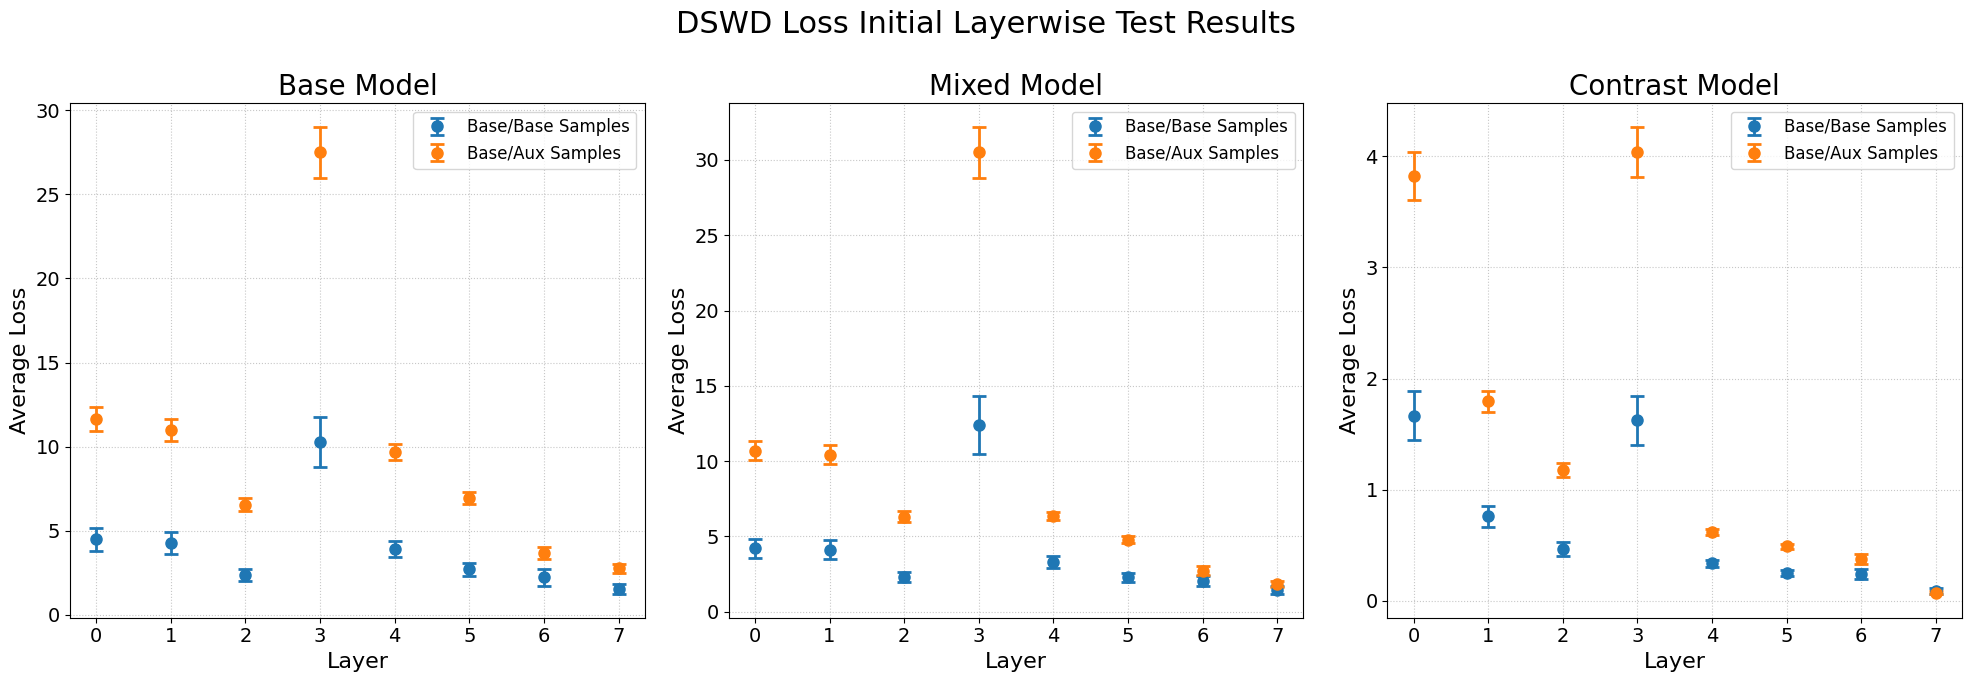

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('DSWD Loss Initial Layerwise Test Results', fontsize=22)

categories = ['base', 'mixed', 'contrast']
modes = ['Base/Base', 'Base/Aux']

def dict_to_array(data_dict):
    return np.array([data_dict[str(i)] for i in range(10)])

colors = ['#1f77b4', '#ff7f0e']  # Blue, Orange

with open(f"{FILE_FOLDER}/DSW_Loss_Classifier_Only_{BASE}+{AUXILIARY}.pkl", "rb") as f:
    loaded_DSW = pickle.load(f)

for i, cat in enumerate(categories):
    for j in range(2):
        data = loaded_DSW[cat][j]
        array = dict_to_array(data).reshape(-1, 9)

        array = np.delete(array, 6, axis=1)

        means = np.mean(array, axis=0)
        stds = np.std(array, axis=0)
        x = range(8)

        axs[i].grid(True, linestyle=":", alpha=.7)

        axs[i].errorbar(x, means, yerr=stds, capsize=5, marker='o', 
                        color=colors[j], ecolor=colors[j], 
                        markersize=8, linewidth=2, capthick=2,
                        label=f'{modes[j]} Samples', linestyle='none')

    # Increase title font size
    axs[i].set_title(f'{cat.capitalize()} Model', fontsize=20)

    # Increase x-label font size
    axs[i].set_xlabel('Layer', fontsize=16)

    # Increase y-label font size
    axs[i].set_ylabel('Average Loss', fontsize=16)

    # Increase tick label font sizes
    axs[i].tick_params(axis='both', which='major', labelsize=14)

    # Add legend
    axs[i].legend(fontsize=12)

plt.tight_layout()
plt.savefig(f'{IMAGE_FOLDER}/{CLASSIFIER_ID}_DSW_Classifier_Only_{BASE}+{AUXILIARY}_edit.pdf', format="pdf", dpi=300)
plt.show()

### UNET with Base Model
---

In [17]:
base_model = TinyCNN()
base_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/{CLASSIFIER_ID}_base_classifier_{BASE}+{AUXILIARY}.pt", weights_only=True))
base_model.eval()

unet_base = CustomUNET()
unet_base_optimizer = optim.Adam(
    unet_base.parameters(),
    lr = 3e-4,
    weight_decay = 1e-5
)

unet_base_early_stopper = helpers.EarlyStopper(patience=7)
unet_epochs = 50
unet_val_loss = 1e7

for epoch in range(unet_epochs):
    train_loss = helpers.unet_run(
        unet_model=unet_base,
        classifier=base_model,
        optimizer=unet_base_optimizer,
        dataloader=train_loader,
        device=DEVICE,
        train=True
    )

    val_loss = helpers.unet_run(
        unet_model=unet_base,
        classifier=base_model,
        optimizer=unet_base_optimizer,
        dataloader=val_loader,
        device=DEVICE,
        train=False
    )

    classifier_val_loss, classifier_val_acc = helpers.classification_run(
        model=base_model,
        optimizer=None,
        dataloader=val_loader,
        device=DEVICE,
        train=False,
        unet_model=unet_base
    )

    print(f"Epoch {epoch} UNET Loss: {round(train_loss, 4)}, {round(val_loss, 4)}")
    print(f"Epoch {epoch} Classifier Loss: {round(classifier_val_loss, 4)}, Acc: {round(classifier_val_acc*100, 2)}\n")

    if unet_val_loss > val_loss:
        unet_val_loss = val_loss
        torch.save(unet_base.state_dict(), f"{MODEL_FOLDER}/unet_base_model_{BASE}+{AUXILIARY}.pt")

    if unet_base_early_stopper(val_loss):
        break

Epoch 0 Loss: 22.9763, 16.2832
Epoch 0 Loss: 2.8363, Acc: 59.4

Epoch 1 Loss: 12.7543, 18.052
Epoch 1 Loss: 0.4397, Acc: 87.16

Epoch 2 Loss: 9.5564, 16.2977
Epoch 2 Loss: 0.2607, Acc: 92.47

Epoch 3 Loss: 9.0859, 19.5847
Epoch 3 Loss: 0.2648, Acc: 92.57

Epoch 4 Loss: 8.8526, 17.2992
Epoch 4 Loss: 0.2513, Acc: 92.79

Epoch 5 Loss: 8.6557, 14.8701
Epoch 5 Loss: 0.1994, Acc: 93.95

Epoch 6 Loss: 8.5804, 13.1382
Epoch 6 Loss: 0.1952, Acc: 94.09

Epoch 7 Loss: 8.5473, 11.3996
Epoch 7 Loss: 0.1836, Acc: 94.09

Epoch 8 Loss: 8.5356, 12.6732
Epoch 8 Loss: 0.1916, Acc: 94.27

Epoch 9 Loss: 8.7194, 16.1262
Epoch 9 Loss: 0.1934, Acc: 93.83

Epoch 10 Loss: 8.6122, 12.7745
Epoch 10 Loss: 0.1891, Acc: 94.45

Epoch 11 Loss: 8.4764, 15.3777
Epoch 11 Loss: 0.1874, Acc: 94.63

Epoch 12 Loss: 8.3591, 14.321
Epoch 12 Loss: 0.2033, Acc: 93.75

Epoch 13 Loss: 8.4678, 15.959
Epoch 13 Loss: 0.1967, Acc: 94.23

Epoch 14 Loss: 8.3748, 15.8723
Epoch 14 Loss: 0.2007, Acc: 94.11

Epoch 15 Loss: 8.3704, 17.4125
E

### UNET with Mixed Model

In [18]:
mixed_model = TinyCNN()
mixed_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/mixed_classifier_{BASE}+{AUXILIARY}.pt", weights_only=True))
mixed_model.eval()

unet_mixed = CustomUNET()
unet_mixed_optimizer = optim.Adam(
    unet_mixed.parameters(),
    lr = 3e-4,
    weight_decay = 1e-5
)

unet_mixed_early_stopper = helpers.EarlyStopper()
unet_epochs = 20
unet_val_loss = 1e7

for epoch in range(unet_epochs):
    train_loss = helpers.unet_run(
        unet_model=unet_mixed,
        classifier=mixed_model,
        optimizer=unet_mixed_optimizer,
        dataloader=train_loader,
        device=DEVICE,
        train=True
    )

    val_loss = helpers.unet_run(
        unet_model=unet_mixed,
        classifier=mixed_model,
        optimizer=unet_mixed_optimizer,
        dataloader=val_loader,
        device=DEVICE,
        train=False
    )

    classifier_val_loss, classifier_val_acc = helpers.classification_run(
        model=mixed_model,
        optimizer=None,
        dataloader=val_loader,
        device=DEVICE,
        train=False,
        unet_model=unet_mixed
    )

    print(f"Epoch {epoch} UNET Loss: {round(train_loss, 4)}, {round(val_loss, 4)}")
    print(f"Epoch {epoch} Classifier Loss: {round(classifier_val_loss, 4)}, Acc: {round(classifier_val_acc*100, 2)}\n")

    if unet_val_loss > val_loss:
        unet_val_loss = val_loss
        torch.save(unet_mixed.state_dict(), f"{MODEL_FOLDER}/unet_mixed_model_{BASE}+{AUXILIARY}.pt")

    if unet_mixed_early_stopper(val_loss):
        break

Epoch 0 Loss: 30.3696, 22.6709
Epoch 0 Loss: 3.3678, Acc: 53.61

Epoch 1 Loss: 11.7163, 13.7983
Epoch 1 Loss: 0.1455, Acc: 95.63

Epoch 2 Loss: 8.1336, 11.9378
Epoch 2 Loss: 0.1359, Acc: 95.75

Epoch 3 Loss: 7.4861, 11.3781
Epoch 3 Loss: 0.1477, Acc: 94.89

Epoch 4 Loss: 7.2347, 9.5677
Epoch 4 Loss: 0.1322, Acc: 95.75

Epoch 5 Loss: 7.1072, 8.7569
Epoch 5 Loss: 0.1339, Acc: 95.53

Epoch 6 Loss: 6.8864, 9.6962
Epoch 6 Loss: 0.1395, Acc: 95.61

Epoch 7 Loss: 6.8204, 8.9402
Epoch 7 Loss: 0.1377, Acc: 95.23

Epoch 8 Loss: 6.7049, 8.4998
Epoch 8 Loss: 0.1282, Acc: 95.81

Epoch 9 Loss: 6.6885, 7.835
Epoch 9 Loss: 0.146, Acc: 95.29

Epoch 10 Loss: 6.6949, 9.338
Epoch 10 Loss: 0.1369, Acc: 95.43

Epoch 11 Loss: 6.7478, 11.4777
Epoch 11 Loss: 0.1284, Acc: 95.79

Epoch 12 Loss: 6.7188, 9.3936
Epoch 12 Loss: 0.1327, Acc: 95.73

Epoch 13 Loss: 6.5892, 10.3732
Epoch 13 Loss: 0.1238, Acc: 96.09

Epoch 14 Loss: 6.6508, 8.6177
Epoch 14 Loss: 0.1277, Acc: 95.73



### UNET with Contrastive Learning Model

In [19]:
contrast_body = TinyCNN_Headless()
contrast_body.load_state_dict(torch.load(f"{MODEL_FOLDER}/contrast_body_{BASE}+{AUXILIARY}_{round(best_temp, 2)}.pt", weights_only=True))
contrast_body.eval()
contrast_body.to(DEVICE)

proj_head = torch.nn.Linear(32, 128)
proj_head.load_state_dict(torch.load(f"{MODEL_FOLDER}/contrast_proj_{BASE}+{AUXILIARY}_{round(best_temp, 2)}.pt", weights_only=True))
proj_head.eval()
proj_head.to(DEVICE)

unet_contrast = CustomUNET()
unet_contrast_optimizer = optim.Adam(
    unet_contrast.parameters(),
    lr = 3e-4,
    weight_decay = 1e-5
)
unet_contrast.to(DEVICE)

unet_contrast_early_stopper = helpers.EarlyStopper()
unet_epochs = 20
unet_val_loss = 1e7

for epoch in range(unet_epochs):
    train_loss = helpers.unet_run(
        unet_model=unet_contrast,
        classifier=contrast_body,
        optimizer=unet_contrast_optimizer,
        dataloader=train_loader,
        device=DEVICE,
        train=True
    )

    val_loss = helpers.unet_run(
        unet_model=unet_contrast,
        classifier=contrast_body,
        optimizer=unet_contrast_optimizer,
        dataloader=val_loader,
        device=DEVICE,
        train=False
    )

    classifier_val_loss = helpers.contrastive_run(
        model=contrast_body,
        proj_head=proj_head,
        dataloader=val_loader,
        device=DEVICE,
        unet_model=unet_contrast,
        train=False
    )

    print(f"Epoch {epoch} UNET Loss: {round(train_loss, 4)}, {round(val_loss, 4)}")
    print(f"Epoch {epoch} Classifier Loss: {round(classifier_val_loss, 4)}\n")

    if unet_contrast_early_stopper(val_loss) or classifier_val_loss!=classifier_val_loss:
        break

    if unet_val_loss > val_loss:
        unet_val_loss = val_loss
        torch.save(unet_contrast.state_dict(), f"{MODEL_FOLDER}/unet_contrast_model_{BASE}+{AUXILIARY}.pt")

Epoch 0 Loss: 0.45, 0.4852
Epoch 0 Loss: 2.9531

Epoch 1 Loss: 0.2724, 0.3191
Epoch 1 Loss: 2.9567

Epoch 2 Loss: 0.2398, 0.3236
Epoch 2 Loss: 2.9575

Epoch 3 Loss: 0.2379, 0.2853
Epoch 3 Loss: 2.9548

Epoch 4 Loss: 0.2373, 0.2966
Epoch 4 Loss: 2.9592

Epoch 5 Loss: 0.2367, 0.2939
Epoch 5 Loss: 2.968

Epoch 6 Loss: 0.2368, 0.3115
Epoch 6 Loss: 2.9739

Epoch 7 Loss: 0.235, 0.3528
Epoch 7 Loss: 2.9769

Epoch 8 Loss: 0.2329, 0.2975
Epoch 8 Loss: 2.9851



### Finetune Base Model with Base UNET

In [29]:
base_model = TinyCNN()
base_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/base_classifier_{BASE}.pt", weights_only=True))
base_model.train()
base_model.to(DEVICE)

unet_base = CustomUNET()
unet_base.load_state_dict(torch.load(f"{MODEL_FOLDER}/unet_base_model_{BASE}+{AUXILIARY}.pt", weights_only=True))
unet_base.eval()
unet_base.to(DEVICE)

base_ft_optimizer = optim.Adam(
    base_model.parameters(),
    lr = 3e-4,
    weight_decay=1e-5
)

base_ft_early_stopper = helpers.EarlyStopper()
num_base_ft_epochs = 50
base_val = 1e7

for epoch in range(num_base_ft_epochs):
    classifier_train_loss, classifier_train_acc = helpers.classification_run(
        model=base_model,
        optimizer=base_ft_optimizer,
        dataloader=train_loader,
        device=DEVICE,
        train=True,
        unet_model=unet_base
    )

    classifier_val_loss, classifier_val_acc = helpers.classification_run(
        model=mixed_model,
        optimizer=None,
        dataloader=val_loader,
        device=DEVICE,
        mode="base_only",
        train=False
    )

    # classifier_val_loss, classifier_val_acc = helpers.classification_run(
    #     model=mixed_model,
    #     optimizer=None,
    #     dataloader=val_loader,
    #     device=DEVICE,
    #     mode="base_only",
    #     train=False
    # )

    print(f"Epoch {epoch} Classifier Train Loss: {round(classifier_train_loss, 4)}, Acc: {round(classifier_train_acc*100, 2)}")
    print(f"Epoch {epoch} Classifier Val Loss: {round(classifier_val_loss, 4)}, Acc: {round(classifier_val_acc*100, 2)}\n")

    if base_val > classifier_val_loss:
        base_val = classifier_val_loss
        torch.save(base_model.state_dict(), f"{MODEL_FOLDER}/base_classifier_finetuned_{BASE}.pt")

    if base_ft_early_stopper(classifier_val_loss):
        break

Epoch 0 Loss: 0.1376, Acc: 95.84
Epoch 0 Loss: 0.1697, Acc: 94.35

Epoch 1 Loss: 0.125, Acc: 96.21
Epoch 1 Loss: 0.1697, Acc: 94.35

Epoch 2 Loss: 0.1224, Acc: 96.26
Epoch 2 Loss: 0.1697, Acc: 94.35

Epoch 3 Loss: 0.1144, Acc: 96.52
Epoch 3 Loss: 0.1697, Acc: 94.35

Epoch 4 Loss: 0.1147, Acc: 96.49
Epoch 4 Loss: 0.1697, Acc: 94.35

Epoch 5 Loss: 0.11, Acc: 96.63
Epoch 5 Loss: 0.1697, Acc: 94.35

Epoch 6 Loss: 0.1039, Acc: 96.75
Epoch 6 Loss: 0.1697, Acc: 94.35

Epoch 7 Loss: 0.1034, Acc: 96.81
Epoch 7 Loss: 0.1697, Acc: 94.35

Epoch 8 Loss: 0.1024, Acc: 96.85
Epoch 8 Loss: 0.1697, Acc: 94.35

Epoch 9 Loss: 0.0989, Acc: 96.99
Epoch 9 Loss: 0.1697, Acc: 94.35

Epoch 10 Loss: 0.0944, Acc: 97.15
Epoch 10 Loss: 0.1697, Acc: 94.35

Epoch 11 Loss: 0.0917, Acc: 97.12
Epoch 11 Loss: 0.1697, Acc: 94.35

Epoch 12 Loss: 0.0906, Acc: 97.21
Epoch 12 Loss: 0.1697, Acc: 94.35

Epoch 13 Loss: 0.0857, Acc: 97.26
Epoch 13 Loss: 0.1697, Acc: 94.35

Epoch 14 Loss: 0.085, Acc: 97.34
Epoch 14 Loss: 0.1697, A

### Finetune Mixed Model with Mixed UNET

In [34]:
mixed_model = TinyCNN()
mixed_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/mixed_classifier_{BASE}+{AUXILIARY}.pt", weights_only=True))
mixed_model.train()
mixed_model.to(DEVICE)

unet_mixed = CustomUNET()
unet_mixed.load_state_dict(torch.load(f"{MODEL_FOLDER}/unet_mixed_model_{BASE}+{AUXILIARY}.pt", weights_only=True))
unet_mixed.eval()
unet_mixed.to(DEVICE)

mixed_ft_optimizer = optim.Adam(
    mixed_model.parameters(),
    lr = 1e-4,
    weight_decay=1e-5
)

mixed_ft_early_stopper = helpers.EarlyStopper()
num_base_ft_epochs = 50
mixed_val = 1e7

for epoch in range(num_base_ft_epochs):
    classifier_train_loss, classifier_train_acc = helpers.classification_run(
        model=mixed_model,
        optimizer=mixed_ft_optimizer,
        dataloader=train_loader,
        device=DEVICE,
        train=True,
        unet_model=unet_mixed
    )

    classifier_val_loss, classifier_val_acc = helpers.classification_run(
        model=mixed_model,
        optimizer=None,
        dataloader=val_loader,
        device=DEVICE,
        mode="base_only",
        train=False
    )

    print(f"Epoch {epoch} Classifier Train Loss: {round(classifier_train_loss, 4)}, Acc: {round(classifier_train_acc*100, 2)}")
    print(f"Epoch {epoch} Classifier Test Loss: {round(classifier_val_loss, 4)}, Acc: {round(classifier_val_acc*100, 2)}\n")

    if mixed_val > classifier_val_loss:
        mixed_val = classifier_val_loss
        torch.save(mixed_model.state_dict(), f"{MODEL_FOLDER}/mixed_classifier_finetuned_{BASE}+{AUXILIARY}.pt")

    if mixed_ft_early_stopper(classifier_val_loss):
        break

Epoch 0 Loss: 0.1075, Acc: 96.52
Epoch 0 Loss: 0.1614, Acc: 94.91

Epoch 1 Loss: 0.1004, Acc: 96.87
Epoch 1 Loss: 0.1544, Acc: 94.99

Epoch 2 Loss: 0.0953, Acc: 97.0
Epoch 2 Loss: 0.1564, Acc: 94.87

Epoch 3 Loss: 0.0942, Acc: 97.08
Epoch 3 Loss: 0.1556, Acc: 94.83

Epoch 4 Loss: 0.0959, Acc: 96.93
Epoch 4 Loss: 0.1536, Acc: 95.03

Epoch 5 Loss: 0.0905, Acc: 97.21
Epoch 5 Loss: 0.154, Acc: 95.19

Epoch 6 Loss: 0.091, Acc: 97.07
Epoch 6 Loss: 0.1579, Acc: 94.99

Epoch 7 Loss: 0.0914, Acc: 97.08
Epoch 7 Loss: 0.1549, Acc: 95.11

Epoch 8 Loss: 0.0894, Acc: 97.18
Epoch 8 Loss: 0.1566, Acc: 94.99

Epoch 9 Loss: 0.0876, Acc: 97.28
Epoch 9 Loss: 0.1537, Acc: 95.15



### Finetune Contrast Model with Contrast UNET

#### Retrain Body

In [50]:
contrast_body = TinyCNN_Headless()
contrast_body.load_state_dict(torch.load(f"{MODEL_FOLDER}/contrast_body_{BASE}+{AUXILIARY}_{round(best_temp, 2)}.pt", weights_only=True))
contrast_body.train()
contrast_body.to(DEVICE)

proj_head = torch.nn.Linear(32, 128)
proj_head.load_state_dict(torch.load(f"{MODEL_FOLDER}/contrast_proj_{BASE}+{AUXILIARY}_{round(best_temp, 2)}.pt", weights_only=True))
proj_head.train()
proj_head.to(DEVICE)

unet_contrast = CustomUNET()
unet_contrast.load_state_dict(torch.load(f"{MODEL_FOLDER}/unet_contrast_model_{BASE}+{AUXILIARY}.pt", weights_only=True))
unet_contrast.eval()
unet_contrast.to(DEVICE)

contrast_ft_optimizer = optim.Adam(
    list(contrast_body.parameters()) + list(proj_head.parameters()),
    lr=1e-4, 
    weight_decay=1e-5
)

contrast_ft_early_stopper = helpers.EarlyStopper()
num_base_ft_epochs = 50
contrast_val = 1e7

unet_contrast_early_stopper = helpers.EarlyStopper()
contrast_epochs = 50
unet_val_loss = 1e7

for epoch in range(contrast_epochs):
    classifier_train_loss = helpers.contrastive_run(
        model=contrast_body,
        proj_head=proj_head,
        optimizer=contrast_ft_optimizer,
        dataloader=train_loader,
        device=DEVICE,
        unet_model=unet_contrast,
        train=True
    )

    classifier_val_loss = helpers.contrastive_run(
        model=contrast_body,
        proj_head=proj_head,
        optimizer=None,
        dataloader=val_loader,
        device=DEVICE,
        unet_model=unet_contrast,
        train=False
    )

    print(f"Epoch {epoch} Contrast Classifier Loss: {round(classifier_train_loss, 4)}, {round(classifier_val_loss, 4)}")

    if contrast_val > classifier_val_loss:
        contrast_val = classifier_val_loss
        torch.save(contrast_body.state_dict(), f"{MODEL_FOLDER}/contrast_body_finetuned_{BASE}+{AUXILIARY}.pt")

    if unet_contrast_early_stopper(classifier_val_loss):
        break

FileNotFoundError: [Errno 2] No such file or directory: 'models/contrast_body_none+skip_0.05.pt'

### Retrain Head

In [40]:
contrast_body = TinyCNN_Headless()
contrast_body.load_state_dict(torch.load(f"{MODEL_FOLDER}/contrast_body_finetuned_{BASE}+{AUXILIARY}.pt", weights_only=True))
contrast_body.eval()

class_head = TinyCNN_Head()

wrapped_model = WrapperModelTrainHead(
    body = contrast_body,
    head = class_head
)
wrapped_model.to(DEVICE)
optimizer = optim.Adam(
    wrapped_model.head.parameters(),
    lr = 1e-3,
    weight_decay = 1e-5
)

contrast_early_stopper = helpers.EarlyStopper()

unet_contrast = CustomUNET()
unet_contrast.load_state_dict(torch.load(f"{MODEL_FOLDER}/unet_contrast_model_{BASE}+{AUXILIARY}.pt", weights_only=True))
unet_contrast.eval()
unet_contrast.to(DEVICE)

num_class_epochs = 50
contrast_val = 1e7

for epoch in range(num_class_epochs):
    train_loss, train_acc = helpers.classification_run(
        model=wrapped_model,
        optimizer=optimizer,
        dataloader=train_loader,
        mode="base_only",
        unet_model=unet_contrast,
        device=DEVICE,
    )

    val_loss, val_acc = helpers.classification_run(
        model=wrapped_model,
        optimizer=None,
        dataloader=val_loader,
        device=DEVICE,
        mode="base_only",
        train=False
    )

    print(f"Epoch {epoch}:", "Train Loss/Acc:", round(train_loss, 4), round(train_acc*100, 2), "Val Loss/Acc:", round(val_loss, 4), round(val_acc*100, 2))

    if contrast_early_stopper(val_loss):
        break

    if val_loss < contrast_val:
        contrast_val = val_loss
        torch.save(wrapped_model.state_dict(), f"{MODEL_FOLDER}/contrast_classifier_finetuned_{BASE}+{AUXILIARY}.pt")

Epoch 0: 2.0436 59.4 1.6973 90.14
Epoch 1: 1.052 95.77 0.7882 94.99
Epoch 2: 0.4374 97.2 0.4334 95.23
Epoch 3: 0.2472 97.87 0.3019 95.47
Epoch 4: 0.18 97.93 0.2405 95.63
Epoch 5: 0.1438 98.06 0.2062 95.55
Epoch 6: 0.1191 98.16 0.1857 95.75
Epoch 7: 0.1054 98.17 0.1722 95.67
Epoch 8: 0.1007 98.16 0.1629 95.67
Epoch 9: 0.0928 98.24 0.1563 95.87
Epoch 10: 0.0934 98.17 0.1515 95.95
Epoch 11: 0.0856 98.22 0.1491 95.83
Epoch 12: 0.0781 98.39 0.1455 95.83
Epoch 13: 0.0775 98.33 0.1439 95.83
Epoch 14: 0.0758 98.34 0.1418 95.87
Epoch 15: 0.0751 98.36 0.1417 95.99
Epoch 16: 0.0724 98.35 0.1414 95.87
Epoch 17: 0.0688 98.44 0.1402 95.91
Epoch 18: 0.0717 98.4 0.1387 95.91
Epoch 19: 0.0646 98.54 0.1378 95.91
Epoch 20: 0.0752 98.23 0.1379 95.87
Epoch 21: 0.0632 98.49 0.1392 95.79
Epoch 22: 0.069 98.35 0.1375 95.87
Epoch 23: 0.0706 98.29 0.1387 95.91
Epoch 24: 0.063 98.47 0.1386 95.79
Epoch 25: 0.0699 98.28 0.138 95.91
Epoch 26: 0.066 98.42 0.1382 95.83
Epoch 27: 0.0681 98.37 0.1375 95.79
Epoch 28: 0.

### Compare Accuracies Between Models

In [41]:
base_model = TinyCNN()
base_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/base_classifier_finetuned_{BASE}.pt", weights_only=True))
base_model.to(DEVICE)
base_loss, base_acc = helpers.classification_run(
    model=base_model,
    optimizer=optimizer,
    dataloader=val_loader,
    device=DEVICE,
    mode="base_only",
    train=False
)

mixed_model = TinyCNN()
mixed_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/mixed_classifier_finetuned_{BASE}+{AUXILIARY}.pt", weights_only=True))
mixed_model.to(DEVICE)
mixed_loss, mixed_acc = helpers.classification_run(
    model=mixed_model,
    optimizer=optimizer,
    dataloader=val_loader,
    device=DEVICE,
    mode="base_only",
    train=False
)

contrast_body = TinyCNN_Headless()
contrast_head = TinyCNN_Head()

contrast_model = WrapperModelTrainHead(
    body=contrast_body,
    head=contrast_head
)
contrast_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/contrast_classifier_finetuned_{BASE}+{AUXILIARY}.pt", weights_only=True))
contrast_model.to(DEVICE)

contrast_loss, contrast_acc = helpers.classification_run(
    model=contrast_model,
    optimizer=optimizer,
    dataloader=val_loader,
    device=DEVICE,
    mode="base_only",
    train=False
)

print(f"Base: {round(base_loss, 4)}, {round(base_acc*100, 2)}")
print(f"Base + Aux Mixed: {round(mixed_loss, 4)}, {round(mixed_acc*100, 2)}")
print(f"Base + Aux Contrast:  {round(contrast_loss, 4)}, {round(contrast_acc*100, 2)}")

Base: 0.1504, 95.51
Base + Aux: 0.1536, 95.03
Base + Aux: 0.1362, 95.83


### Plot Latent Space Representations

In [43]:
base_model = TinyCNN()
base_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/base_classifier_finetuned_{BASE}.pt", weights_only=True))
base_model.eval()

unet_base = CustomUNET()
unet_base.load_state_dict(torch.load(f"{MODEL_FOLDER}/unet_base_model_{BASE}+{AUXILIARY}.pt", weights_only=True))
unet_base.eval()

mixed_model = TinyCNN()
mixed_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/mixed_classifier_finetuned_{BASE}+{AUXILIARY}.pt", weights_only=True))
mixed_model.eval()

unet_mixed = CustomUNET()
unet_mixed.load_state_dict(torch.load(f"{MODEL_FOLDER}/unet_mixed_model_{BASE}+{AUXILIARY}.pt", weights_only=True))
unet_mixed.eval()

contrast_body = TinyCNN_Headless()
contrast_head = TinyCNN_Head()

contrast_model = WrapperModelTrainHead(
    body=contrast_body,
    head=contrast_head
)

contrast_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/contrast_classifier_finetuned_{BASE}+{AUXILIARY}.pt", weights_only=True))
contrast_model.eval()

unet_contrast = CustomUNET()
unet_contrast.load_state_dict(torch.load(f"{MODEL_FOLDER}/unet_contrast_model_{BASE}+{AUXILIARY}.pt", weights_only=True))
unet_contrast.eval()

contrast_model.to(DEVICE)
base_model.to(DEVICE)
mixed_model.to(DEVICE)

unet_contrast.to(DEVICE)
unet_base.to(DEVICE)
unet_mixed.to(DEVICE)

base_embeds_base = np.zeros((len(test_dataset), 32))
base_embeds_aux = np.zeros((len(test_dataset), 32))
mixed_embeds_base = np.zeros((len(test_dataset), 32))
mixed_embeds_aux = np.zeros((len(test_dataset), 32))
contrast_embeds_base = np.zeros((len(test_dataset), 32))
contrast_embeds_aux = np.zeros((len(test_dataset), 32))
labels = np.zeros(len(test_dataset))

test_loader.dataset.unique_sources = True
bs = val_loader.batch_size

for i, (x,y,z) in enumerate(test_loader):
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    with torch.no_grad():
        y_base = unet_base(y)
        y_mixed = unet_mixed(y)
        y_contrast = unet_contrast(y)

        base_outputs_base = base_model(x)[9].cpu().numpy()
        base_outputs_aux = base_model(y_base)[9].cpu().numpy()
        mixed_outputs_base = mixed_model(x)[9].cpu().numpy()
        mixed_outputs_aux = mixed_model(y_mixed)[9].cpu().numpy()
        contrast_outputs_base = contrast_model(x)[9].cpu().numpy()
        contrast_outputs_aux = contrast_model(y_contrast)[9].cpu().numpy()

        base_embeds_base[i*bs:i*bs+bs] = base_outputs_base
        base_embeds_aux[i*bs:i*bs+bs] = base_outputs_aux
        mixed_embeds_base[i*bs:i*bs+bs] = mixed_outputs_base
        mixed_embeds_aux[i*bs:i*bs+bs] = mixed_outputs_aux
        contrast_embeds_base[i*bs:i*bs+bs] = contrast_outputs_base
        contrast_embeds_aux[i*bs:i*bs+bs] = contrast_outputs_aux
        labels[i*bs:i*bs+bs] = z.cpu()


C:\Users\Justin\AppData\Local\Temp\ipykernel_32724\3664967421.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab20 = plt.cm.get_cmap('tab20')
C:\Users\Justin\AppData\Local\Temp\ipykernel_32724\3664967421.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab20 = plt.cm.get_cmap('tab20')


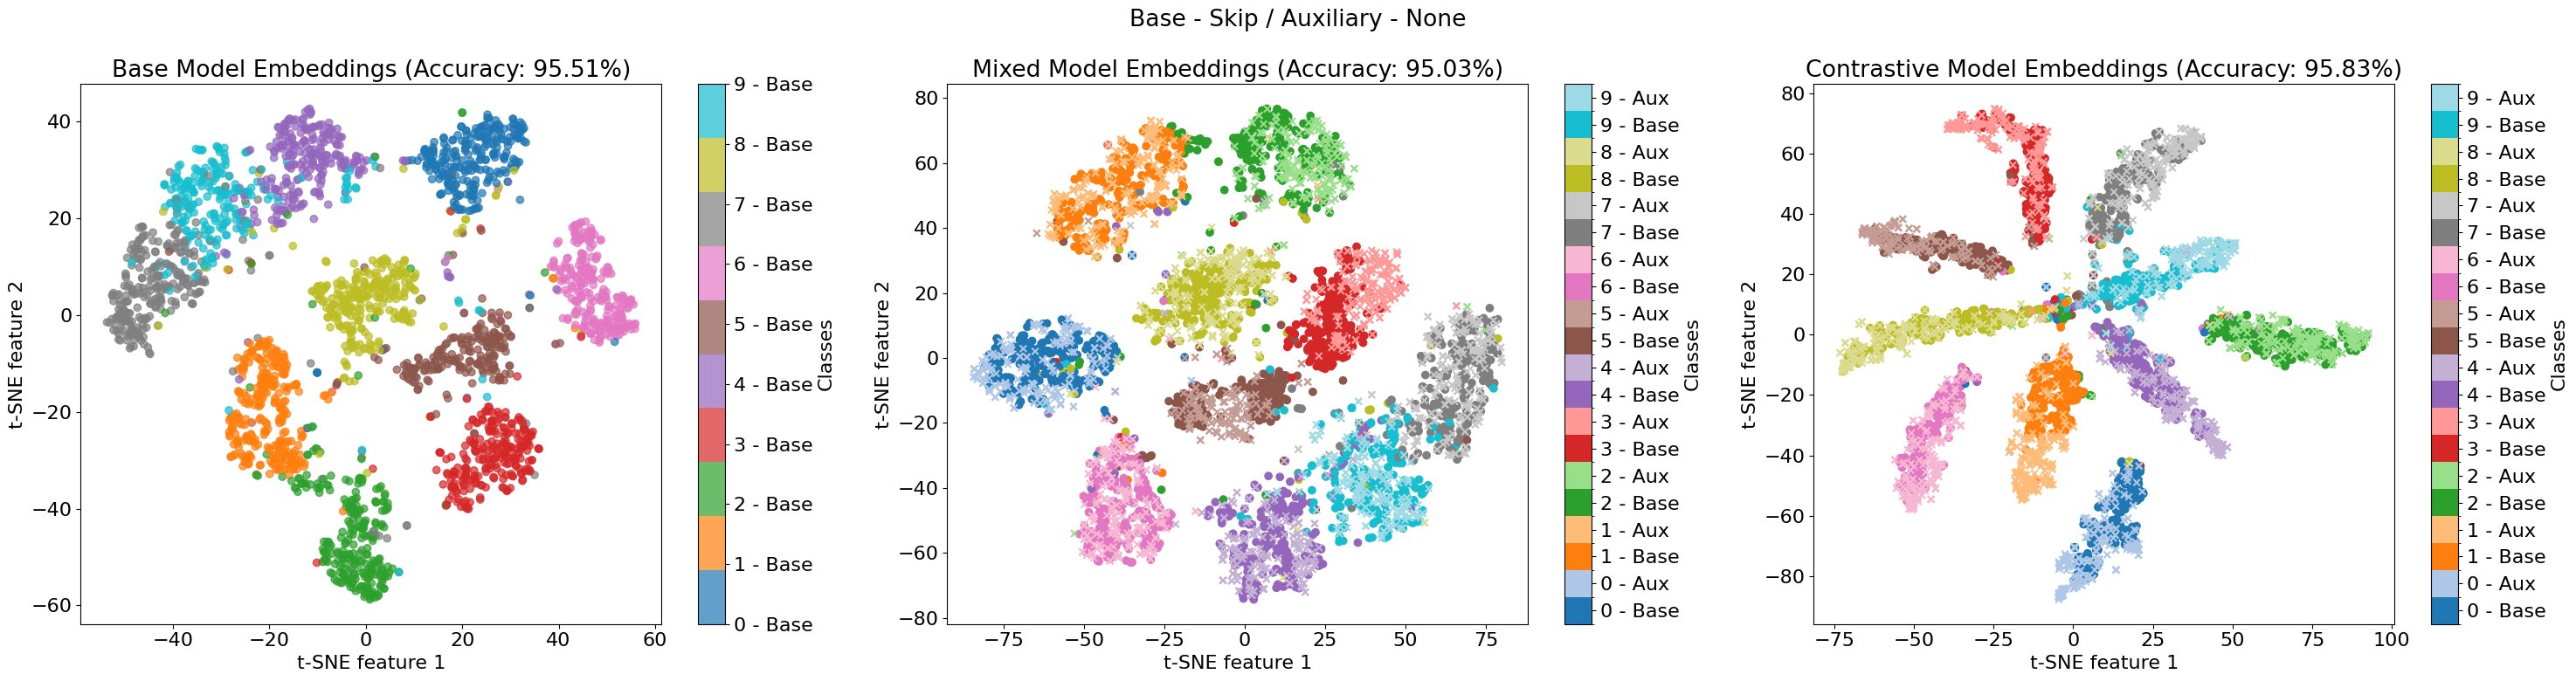

In [44]:
base_labels = np.concatenate((labels*2, labels*2+1))
base_embeds = np.concatenate((base_embeds_base, base_embeds_aux))

mixed_labels = np.concatenate((labels*2, labels*2+1))
mixed_embeds = np.concatenate((mixed_embeds_base, mixed_embeds_aux))

contrast_labels = np.concatenate((labels*2, labels*2+1))
contrast_embeds = np.concatenate((contrast_embeds_base, contrast_embeds_aux))

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

plt.rcParams['font.size'] = 16

# Perform t-SNE for all three embedding sets
tsne = TSNE(n_components=2, random_state=42)
base_tsne = tsne.fit_transform(base_embeds_base)
mixed_tsne = tsne.fit_transform(mixed_embeds)
contrast_tsne = tsne.fit_transform(contrast_embeds)

# Convert labels to numpy if it's a torch tensor
if isinstance(labels, torch.Tensor):
    labels = labels.numpy()

# Create three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))

# Plot for base embeddings
scatter1 = ax1.scatter(base_tsne[:, 0], base_tsne[:, 1], c=labels, cmap='tab10', alpha=.7)
ax1.set_title(f'Base Model Embeddings (Accuracy: {round(base_acc*100, 2)}%)')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
cbar = fig.colorbar(scatter1, ax=ax1)
ticks = np.arange(0, 10)
c_labels = [ 
    "0 - Base",
    "1 - Base",
    "2 - Base",
    "3 - Base",
    "4 - Base",
    "5 - Base",
    "6 - Base",
    "7 - Base",
    "8 - Base",
    "9 - Base",
]
cbar.set_ticks(ticks)
cbar.set_ticklabels(c_labels)
cbar.set_label("Classes")

tab20 = plt.cm.get_cmap('tab20')
color_dict = {i: tab20(i/20) for i in range(20)}

scatter2a = ax2.scatter(mixed_tsne[:len(mixed_tsne)//2, 0], mixed_tsne[:len(mixed_tsne)//2, 1], c=[color_dict[label] for label in mixed_labels[:len(mixed_tsne)//2]])
scatter2b = ax2.scatter(mixed_tsne[len(mixed_tsne)//2:, 0], mixed_tsne[len(mixed_tsne)//2:, 1], c=[color_dict[label] for label in mixed_labels[len(mixed_tsne)//2:]], marker="x", s=30)
ax2.set_title(f'Mixed Model Embeddings (Accuracy: {round(mixed_acc*100, 2)}%)')
ax2.set_xlabel('t-SNE feature 1')
ax2.set_ylabel('t-SNE feature 2')
colors = [color_dict[i] for i in range(20)]
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(21)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax2, ticks=np.arange(0.5, 20))

c_labels = [
    "0 - Base", "0 - Aux",
    "1 - Base", "1 - Aux",
    "2 - Base", "2 - Aux",
    "3 - Base", "3 - Aux",
    "4 - Base", "4 - Aux",
    "5 - Base", "5 - Aux",
    "6 - Base", "6 - Aux",
    "7 - Base", "7 - Aux",
    "8 - Base", "8 - Aux",
    "9 - Base", "9 - Aux",
]
cbar.set_ticklabels(c_labels)
cbar.set_label("Classes")


# Plot for contrast embeddings
tab20 = plt.cm.get_cmap('tab20')
color_dict = {i: tab20(i/20) for i in range(20)}

scatter3a = ax3.scatter(contrast_tsne[:len(contrast_tsne)//2, 0], contrast_tsne[:len(contrast_tsne)//2, 1], c=[color_dict[label] for label in contrast_labels[:len(contrast_tsne)//2]])
scatter3b = ax3.scatter(contrast_tsne[len(contrast_tsne)//2:, 0], contrast_tsne[len(contrast_tsne)//2:, 1], c=[color_dict[label] for label in contrast_labels[len(contrast_tsne)//2:]], marker="x", s=30)
ax3.set_title(f'Contrastive Model Embeddings (Accuracy: {round(contrast_acc*100, 2)}%)')
ax3.set_xlabel('t-SNE feature 1')
ax3.set_ylabel('t-SNE feature 2')
colors = [color_dict[i] for i in range(20)]
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(21)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax3, ticks=np.arange(0.5, 20))

c_labels = [
    "0 - Base", "0 - Aux",
    "1 - Base", "1 - Aux",
    "2 - Base", "2 - Aux",
    "3 - Base", "3 - Aux",
    "4 - Base", "4 - Aux",
    "5 - Base", "5 - Aux",
    "6 - Base", "6 - Aux",
    "7 - Base", "7 - Aux",
    "8 - Base", "8 - Aux",
    "9 - Base", "9 - Aux",
]
cbar.set_ticklabels(c_labels)
cbar.set_label("Classes")

fig.suptitle(f"Base - {base.capitalize()} / Auxiliary - {aux.capitalize()}")

plt.tight_layout()
plt.savefig(f'images/tsne_{BASE}+{AUXILIARY}_unet_first_run.pdf', format="pdf", dpi=300)
plt.show()

### Plot New DSWD Loss with UNET

In [ ]:
base_model = TinyCNN()
base_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/base_classifier_finetuned_{BASE}.pt", weights_only=True))
base_model.eval()

unet_base = CustomUNET()
unet_base.load_state_dict(torch.load(f"{MODEL_FOLDER}/unet_base_model_{BASE}+{AUXILIARY}.pt", weights_only=True))
unet_base.eval()

mixed_model = TinyCNN()
mixed_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/mixed_classifier_finetuned_{BASE}+{AUXILIARY}.pt", weights_only=True))
mixed_model.eval()

unet_mixed = CustomUNET()
unet_mixed.load_state_dict(torch.load(f"{MODEL_FOLDER}/unet_mixed_model_{BASE}+{AUXILIARY}.pt", weights_only=True))
unet_mixed.eval()

contrast_body = TinyCNN_Headless()
contrast_head = TinyCNN_Head()

contrast_model = WrapperModelTrainHead(
    body=contrast_body,
    head=contrast_head
)

contrast_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/contrast_classifier_finetuned_{BASE}+{AUXILIARY}.pt", weights_only=True))
contrast_model.eval()

unet_contrast = CustomUNET()
unet_contrast.load_state_dict(torch.load(f"{MODEL_FOLDER}/unet_contrast_model_{BASE}+{AUXILIARY}.pt", weights_only=True))
unet_contrast.eval()

contrast_model.to(DEVICE)
base_model.to(DEVICE)
mixed_model.to(DEVICE)

unet_contrast.to(DEVICE)
unet_base.to(DEVICE)
unet_mixed.to(DEVICE)

print("loaded all finetuned classifiers and UNET")

In [ ]:
dswd_loss_test = {
    "base": [],
    "mixed": [],
    "contrast": [],
}
# 2 - base or mixed

networks = {
    "base": [base_model, unet_base],
    "mixed": [mixed_model, unet_mixed],
    "contrast": [contrast_model, unet_contrast],
}

for i, network in enumerate(networks.keys()):
    print(f"Starting network {network} : {i+1}/{len(networks)}")

    dswd_loss_mixed, class_hist = helpers.run_dswd_all_classes(
        model=networks[network][0],
        dataloader=test_loader,
        layers=8,
        device=DEVICE,
        base_only=False,
        unet_model=networks[network][1],
        num_projections=256
    )
    dswd_loss_test[network].append(dswd_loss_mixed)

with open(f"{FILE_FOLDER}/DSW_Loss_Classifier+UNET_{BASE}+{AUXILIARY}.pkl", "wb") as f:
    pickle.dump(dswd_loss_test, f)

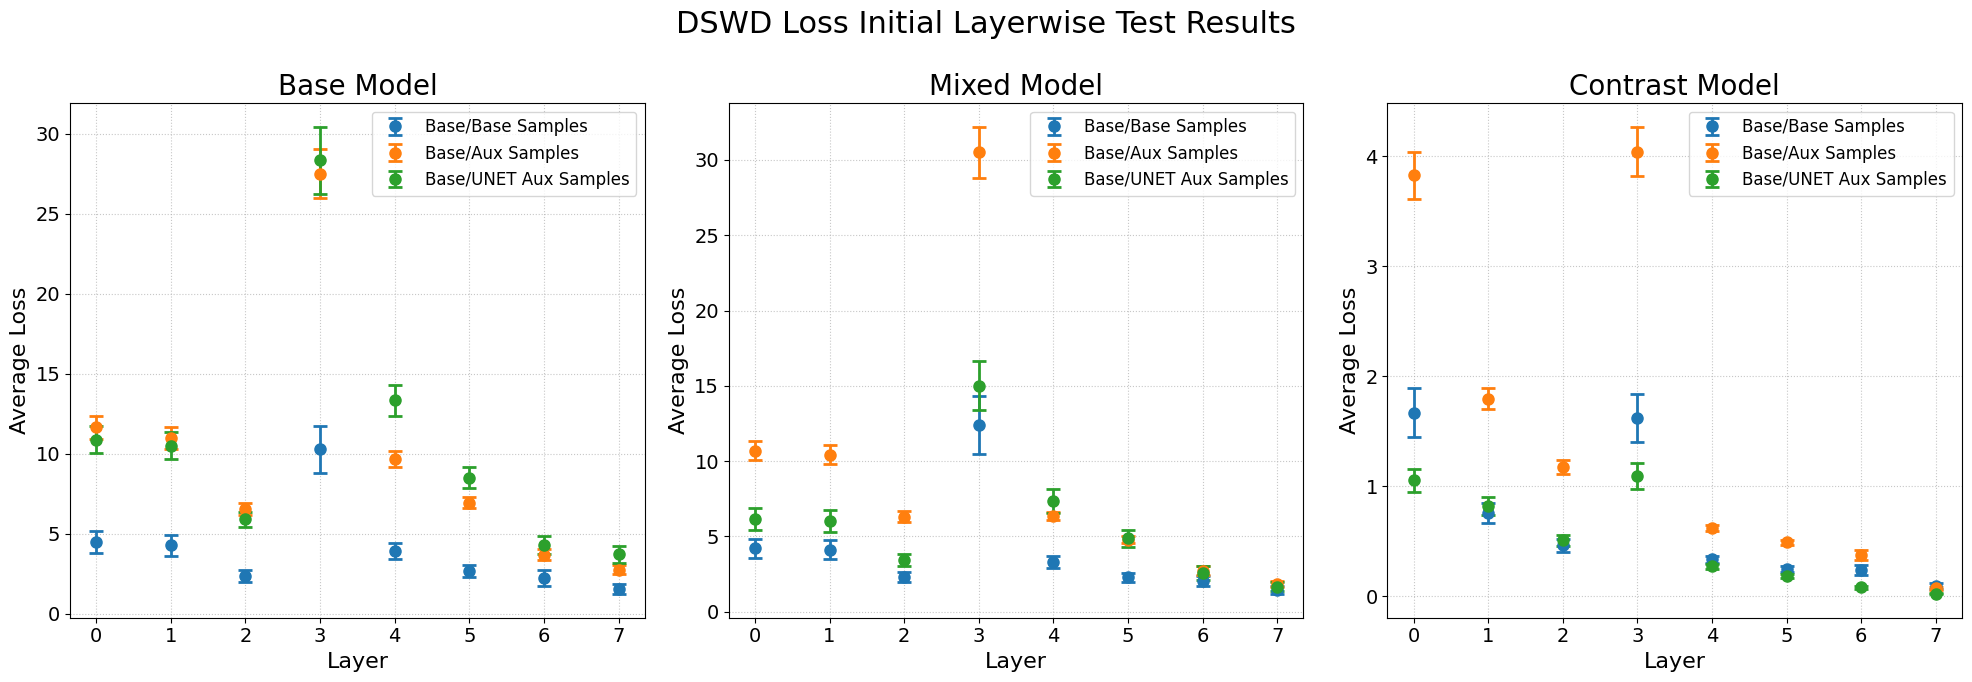

In [33]:
with open(f"{FILE_FOLDER}/DSW_Loss_Classifier_{BASE}+{AUXILIARY}.pkl", "wb") as f:
    loaded_first = pickle.load(f)

with open(f"{FILE_FOLDER}/DSW_Loss_Classifier+UNET_{BASE}+{AUXILIARY}.pkl", "wb") as f:
    loaded_second = pickle.load(f)

fig, axs = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('DSWD Loss Classifier+ Layerwise Test Results', fontsize=22)

categories = ['base', 'mixed', 'contrast']
modes = ['Base/Base', 'Base/Aux', 'Base/UNET Aux']

def dict_to_array(data_dict):
    return np.array([data_dict[str(i)] for i in range(10)])

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange

for i, cat in enumerate(categories):
    for j in range(3):
        if j < 2:
            data = loaded_first[cat][j]
        else:
            data = loaded_second[cat][0]

        array = dict_to_array(data).reshape(-1, 9)

        array = np.delete(array, 6, axis=1)

        means = np.mean(array, axis=0)
        stds = np.std(array, axis=0)
        x = range(8)

        axs[i].grid(True, linestyle=":", alpha=.7)

        axs[i].errorbar(x, means, yerr=stds, capsize=5, marker='o', 
                        color=colors[j], ecolor=colors[j], 
                        markersize=8, linewidth=2, capthick=2,
                        label=f'{modes[j]} Samples', linestyle='none')

    # Increase title font size
    axs[i].set_title(f'{cat.capitalize()} Model', fontsize=20)

    # Increase x-label font size
    axs[i].set_xlabel('Layer', fontsize=16)

    # Increase y-label font size
    axs[i].set_ylabel('Average Loss', fontsize=16)

    # Increase tick label font sizes
    axs[i].tick_params(axis='both', which='major', labelsize=14)

    # Add legend
    axs[i].legend(fontsize=12)

plt.tight_layout()
plt.savefig(f'images/DSW_unet_{BASE}+{AUXILIARY}.pdf', format="pdf", dpi=300)
plt.show()

### Plotting UNET Outputs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08358812..1.1888863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11098157..1.2408133].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06660588..1.2216276].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06090964..1.2139573].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.101561084..1.0691082].


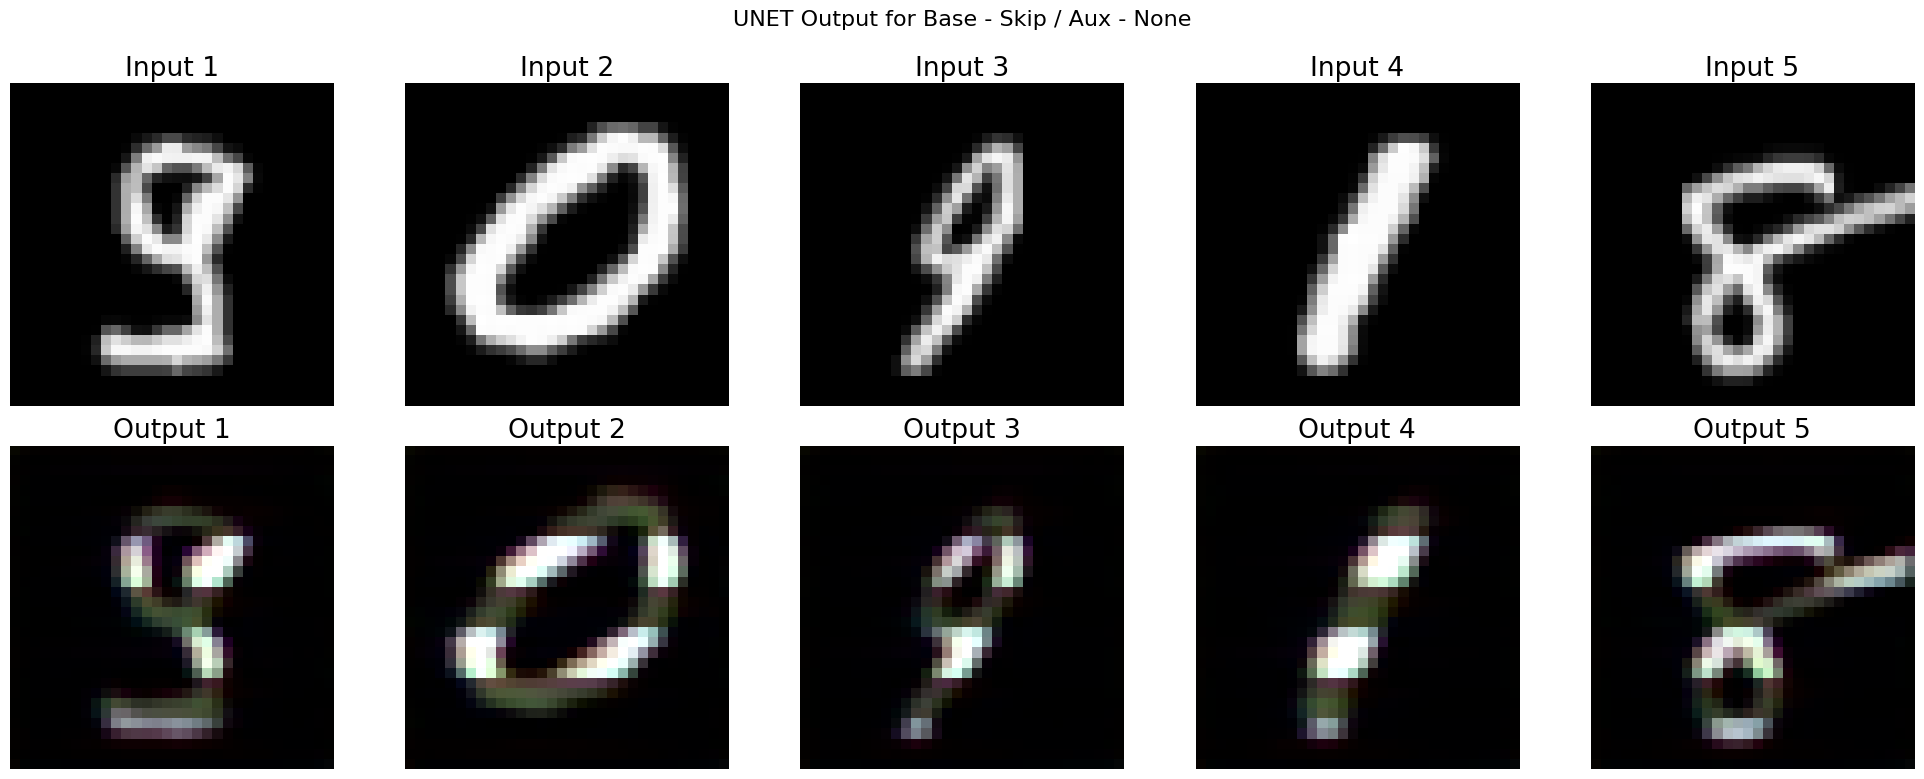

In [69]:
import matplotlib.pyplot as plt
import torch

test_loader.dataset.unique_sources = True

for x, y, z in test_loader:
    y=y.to(DEVICE)
    unet_contrast.to(DEVICE)

    output= unet_contrast(y)
    break

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('UNET Output for Base - Skip / Aux - None', fontsize=16)

for i in range(5):
    # Plot image from y tensor (top row)
    img_y = y[i].permute(1, 2, 0).cpu().numpy()
    axs[0, i].imshow(img_y)
    axs[0, i].axis('off')
    axs[0, i].set_title(f'Input {i+1}')

    # Plot image from output tensor (bottom row)
    img_output = output[i].permute(1, 2, 0).cpu().detach().numpy()
    axs[1, i].imshow(img_output)
    axs[1, i].axis('off')
    axs[1, i].set_title(f'Output {i+1}')

plt.tight_layout()
plt.savefig(f'images/unet_contrast_output_{BASE}+{AUXILIARY}.pdf', format="pdf", dpi=300)
plt.show()


### Iteratively Finetune Base Classifier + Base UNET

In [ ]:
base_model = TinyCNN()
base_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/base_classifier_{BASE}.pt", weights_only=True))
base_model.train()
base_model.to(DEVICE)

unet_base = CustomUNET()
unet_base.load_state_dict(torch.load(f"{MODEL_FOLDER}/unet_base_model_{BASE}+{AUXILIARY}.pt", weights_only=True))
unet_base.eval()
unet_base.to(DEVICE)

base_ft_optimizer = optim.Adam(
    base_model.parameters(),
    lr = 3e-4,
    weight_decay=1e-5
)

unet_base_ft_optimizer = optim.Adam(
    unet_base.parameters(),
    lr = 3e-4,
    weight_decay = 1e-5
)

base_ft_early_stopper = helpers.EarlyStopper()
num_base_ft_epochs = 50
base_val = 1e7

for epoch in range(num_base_ft_epochs):
    train_loss = helpers.unet_run(
        unet_model=unet_base,
        classifier=base_model,
        optimizer=unet_base_ft_optimizer,
        dataloader=train_loader,
        device=DEVICE,
        train=True
    )

    val_loss = helpers.unet_run(
        unet_model=unet_base,
        classifier=base_model,
        optimizer=unet_base_ft_optimizer,
        dataloader=val_loader,
        device=DEVICE,
        train=False
    )

    classifier_train_loss, classifier_train_acc = helpers.classification_run(
        model=base_model,
        optimizer=base_ft_optimizer,
        dataloader=train_loader,
        device=DEVICE,
        train=True,
        unet_model=unet_base
    )

    classifier_val_loss, classifier_val_acc = helpers.classification_run(
        model=base_model,
        optimizer=None,
        dataloader=val_loader,
        device=DEVICE,
        mode="base_only",
        train=False
    )
    
    print(f"Epoch {epoch} UNET Train Loss: {round(train_loss, 4)}")
    print(f"Epoch {epoch} UNET Val Loss: {round(val_loss, 4)}\n")

    print(f"Epoch {epoch} Classifier Train Loss: {round(classifier_train_loss, 4)}, Acc: {round(classifier_train_acc*100, 2)}")
    print(f"Epoch {epoch} Classifier Val Loss: {round(classifier_val_loss, 4)}, Acc: {round(classifier_val_acc*100, 2)}\n")

    if base_val > classifier_val_loss:
        base_val = classifier_val_loss
        torch.save(base_model.state_dict(), f"{MODEL_FOLDER}/base_classifier_full_finetuned_{BASE}.pt")
        torch.save(unet_base.state_dict(), f"{MODEL_FOLDER}/unet_base_model_full_finetuned{BASE}+{AUXILIARY}.pt")

    if base_ft_early_stopper(classifier_val_loss):
        break

### Iteratively Finetune Mixed Classifier + Mixed UNET

In [ ]:
mixed_model = TinyCNN()
mixed_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/mixed_classifier_{BASE}.pt", weights_only=True))
mixed_model.train()
mixed_model.to(DEVICE)

unet_mixed = CustomUNET()
unet_mixed.load_state_dict(torch.load(f"{MODEL_FOLDER}/unet_mixed_model_{BASE}+{AUXILIARY}.pt", weights_only=True))
unet_mixed.eval()
unet_mixed.to(DEVICE)

mixed_ft_optimizer = optim.Adam(
    mixed_model.parameters(),
    lr = 3e-4,
    weight_decay=1e-5
)

unet_mixed_ft_optimizer = optim.Adam(
    unet_mixed.parameters(),
    lr = 3e-4,
    weight_decay = 1e-5
)

mixed_ft_early_stopper = helpers.EarlyStopper()
num_mixed_ft_epochs = 50
mixed_val = 1e7

for epoch in range(num_mixed_ft_epochs):
    train_loss = helpers.unet_run(
        unet_model=unet_mixed,
        classifier=mixed_model,
        optimizer=unet_mixed_ft_optimizer,
        dataloader=train_loader,
        device=DEVICE,
        train=True
    )

    val_loss = helpers.unet_run(
        unet_model=unet_mixed,
        classifier=mixed_model,
        optimizer=unet_mixed_ft_optimizer,
        dataloader=val_loader,
        device=DEVICE,
        train=False
    )

    classifier_train_loss, classifier_train_acc = helpers.classification_run(
        model=mixed_model,
        optimizer=mixed_ft_optimizer,
        dataloader=train_loader,
        device=DEVICE,
        train=True,
        unet_model=unet_mixed
    )

    classifier_val_loss, classifier_val_acc = helpers.classification_run(
        model=mixed_model,
        optimizer=None,
        dataloader=val_loader,
        device=DEVICE,
        mode="base_only",
        train=False
    )
    
    print(f"Epoch {epoch} UNET Train Loss: {round(train_loss, 4)}")
    print(f"Epoch {epoch} UNET Val Loss: {round(val_loss, 4)}\n")

    print(f"Epoch {epoch} Classifier Train Loss: {round(classifier_train_loss, 4)}, Acc: {round(classifier_train_acc*100, 2)}")
    print(f"Epoch {epoch} Classifier Val Loss: {round(classifier_val_loss, 4)}, Acc: {round(classifier_val_acc*100, 2)}\n")

    if mixed_val > classifier_val_loss:
        mixed_val = classifier_val_loss
        torch.save(mixed_model.state_dict(), f"{MODEL_FOLDER}/mixed_classifier_full_finetuned_{BASE}.pt")
        torch.save(unet_mixed.state_dict(), f"{MODEL_FOLDER}/unet_mixed_model_full_finetuned{BASE}+{AUXILIARY}.pt")

    if mixed_ft_early_stopper(classifier_val_loss):
        break

### Iteratively Finetune Contrast Classifier + Contrast UNET (WIP)

In [ ]:
contrast_model = TinyCNN()
contrast_model.load_state_dict(torch.load(f"{MODEL_FOLDER}/contrast_classifier_{BASE}.pt", weights_only=True))
contrast_model.train()
contrast_model.to(DEVICE)

unet_contrast = CustomUNET()
unet_contrast.load_state_dict(torch.load(f"{MODEL_FOLDER}/unet_contrast_model_{BASE}+{AUXILIARY}.pt", weights_only=True))
unet_contrast.eval()
unet_contrast.to(DEVICE)

contrast_ft_optimizer = optim.Adam(
    contrast_model.parameters(),
    lr = 3e-4,
    weight_decay=1e-5
)

unet_contrast_ft_optimizer = optim.Adam(
    unet_contrast.parameters(),
    lr = 3e-4,
    weight_decay = 1e-5
)

contrast_ft_early_stopper = helpers.EarlyStopper()
num_contrast_ft_epochs = 50
contrast_val = 1e7

for epoch in range(num_mixed_ft_epochs):
    train_loss = helpers.unet_run(
        unet_model=unet_contrast,
        classifier=contrast_model,
        optimizer=unet_contrast_ft_optimizer,
        dataloader=train_loader,
        device=DEVICE,
        train=True
    )

    val_loss = helpers.unet_run(
        unet_model=unet_contrast,
        classifier=contrast_model,
        optimizer=unet_contrast_ft_optimizer,
        dataloader=val_loader,
        device=DEVICE,
        train=False
    )

    classifier_train_loss, classifier_train_acc = helpers.classification_run(
        model=mixed_model,
        optimizer=mixed_ft_optimizer,
        dataloader=train_loader,
        device=DEVICE,
        train=True,
        unet_model=unet_mixed
    )

    classifier_val_loss, classifier_val_acc = helpers.classification_run(
        model=mixed_model,
        optimizer=None,
        dataloader=val_loader,
        device=DEVICE,
        mode="base_only",
        train=False
    )
    
    print(f"Epoch {epoch} UNET Train Loss: {round(train_loss, 4)}")
    print(f"Epoch {epoch} UNET Val Loss: {round(val_loss, 4)}\n")

    print(f"Epoch {epoch} Classifier Train Loss: {round(classifier_train_loss, 4)}, Acc: {round(classifier_train_acc*100, 2)}")
    print(f"Epoch {epoch} Classifier Val Loss: {round(classifier_val_loss, 4)}, Acc: {round(classifier_val_acc*100, 2)}\n")

    if contrast_val > classifier_val_loss:
        contrast_val = classifier_val_loss
        torch.save(mixed_model.state_dict(), f"{MODEL_FOLDER}/mixed_classifier_full_finetuned_{BASE}.pt")
        torch.save(unet_mixed.state_dict(), f"{MODEL_FOLDER}/unet_mixed_model_full_finetuned{BASE}+{AUXILIARY}.pt")

    if contrast_ft_early_stopper(classifier_val_loss):
        break